In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pdb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Feature extractors

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(img, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    feature_image = np.copy(img)      

        # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
    return hog_features

In [3]:
# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Sliding Window Search

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):    
    draw_img = np.copy(img)
    img = img.astype(np.float64)/255
    
    img_tosearch = img[ystart:ystop,:,:]    
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    window_cnt = 0
    
    for xb in range(nxsteps):
        for yb in range(nysteps):            
            window_cnt += 1
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #pdb.set_trace()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, 
                                      hog_feat2,
                                      hog_feat3))
        
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            # Append the new feature vector to the features list
          
            # Scale features and make a prediction 
            test_features = np.concatenate((spatial_features, hist_features, hog_features))
          
            #pdb.set_trace()
            test_features = X_scaler.transform(test_features.reshape(1, -1))
            test_prediction = classifier.predict(test_features)[0]
            
            #pdb.set_trace()
            if test_prediction == 1:
                #pdb.set_trace()
                #cv2.imwrite('subimg.png',subimg)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    print('Windows: %d Detected cars: %d'%(window_cnt, len(boxes)))

    return draw_img, boxes


Windows: 273 Detected cars: 10


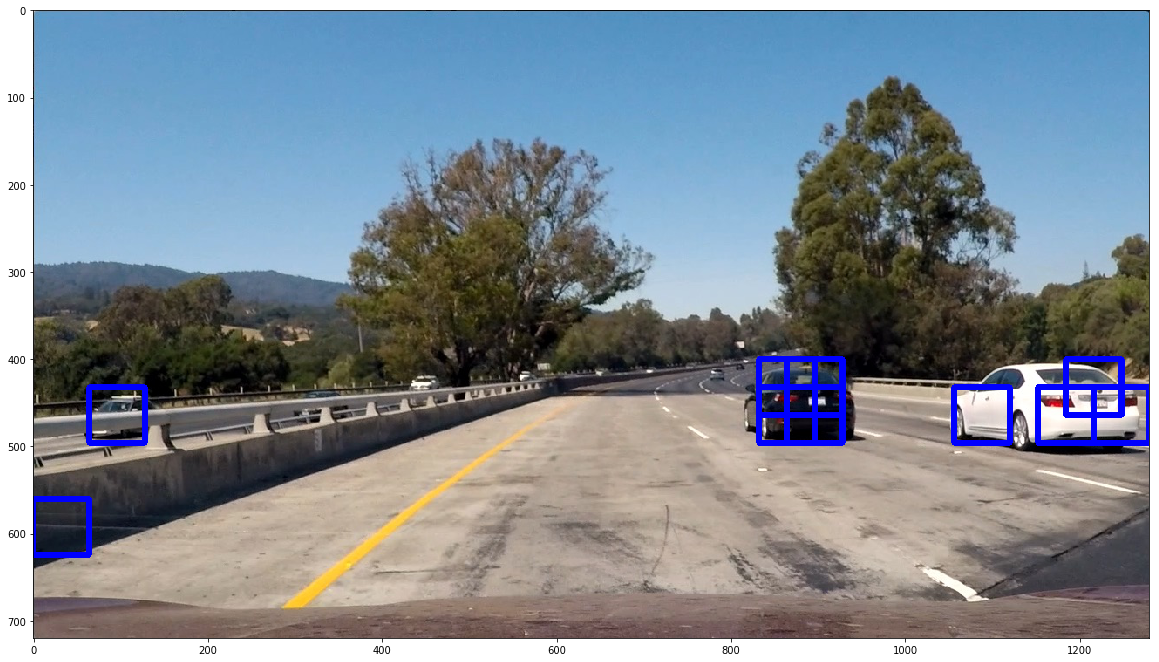

In [5]:
ystart = 400
ystop = 656
scale = 1

img = mpimg.imread('./test_images/test1.jpg')

# load Xgboost classifier model from file
classifier_model, X_scaler = pickle.load(open("xgboost_allfeatures_large.pkl", "rb"))

out_img, boxes = find_cars(img, ystart, ystop, scale, classifier_model, X_scaler, orient, pix_per_cell, cell_per_block)

plt.figure(figsize=(20,20))
plt.imshow(out_img)

Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0


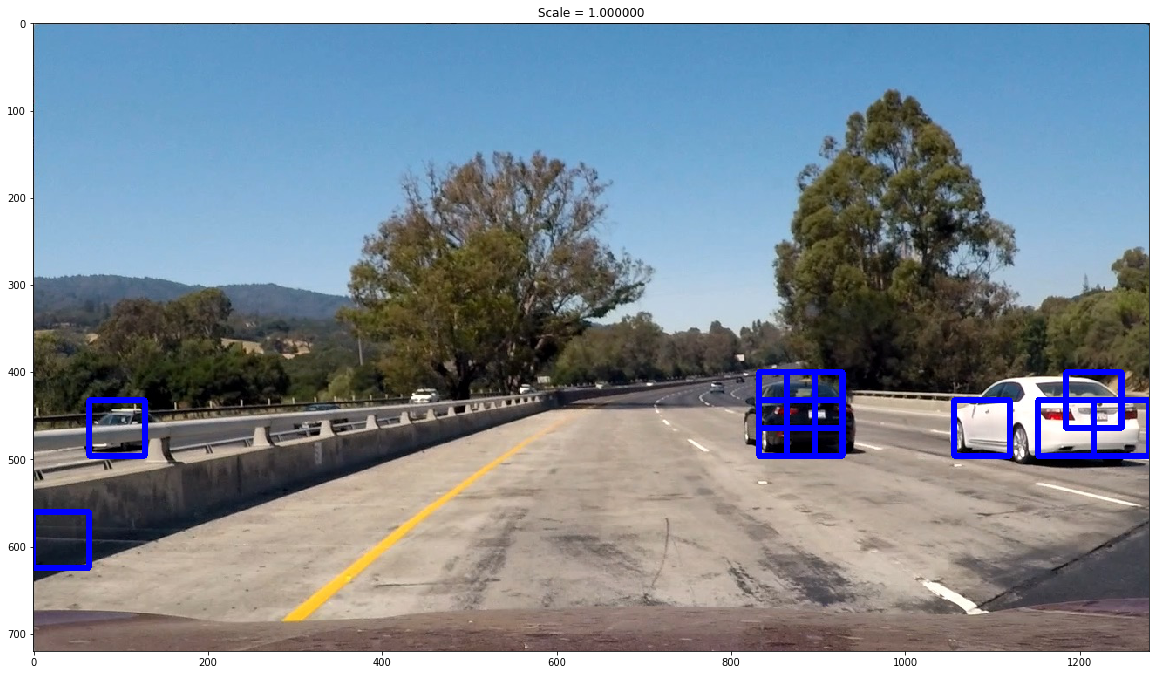

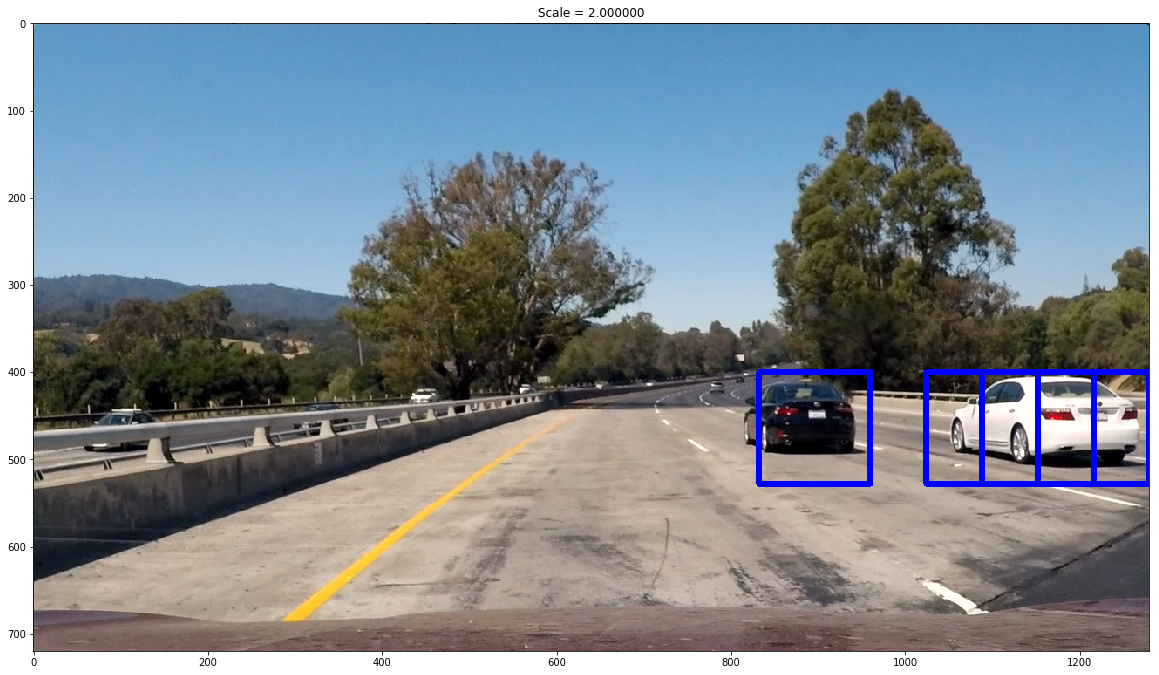

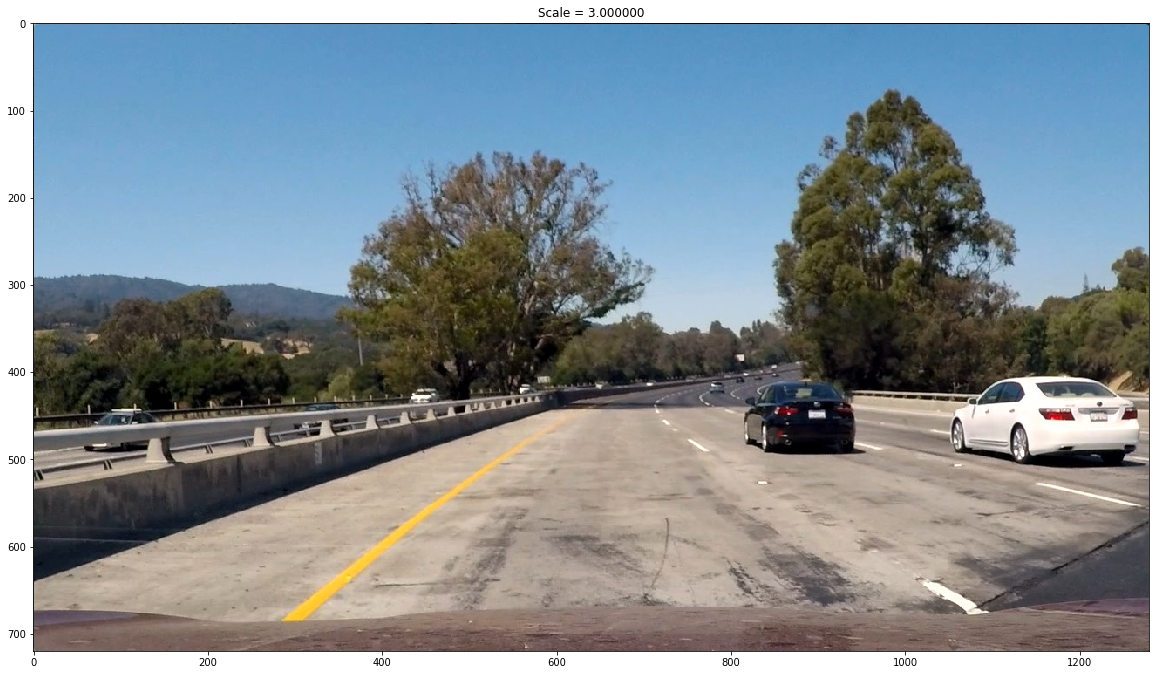

In [8]:
ystart = 400
ystop = 656

boxes = []
for scale in  np.arange(1, 4, 1):    
    out_img, box = find_cars(img, ystart, ystop, scale, classifier_model, X_scaler, orient, pix_per_cell, cell_per_block)
    boxes.extend(box)
    plt.figure(figsize=(20,20))
    plt.title('Scale = %f'%scale)    
    plt.imshow(out_img)
    plt.savefig('./examples/sliding_window_%d'%scale, bbox_inches='tight')

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        font = cv2.FONT_HERSHEY_SIMPLEX
        #cv2.putText(img,'%d'%car_number,bbox[0], font, 4,(255,255,255),2,cv2.LINE_AA)
    # Return the image
    return img

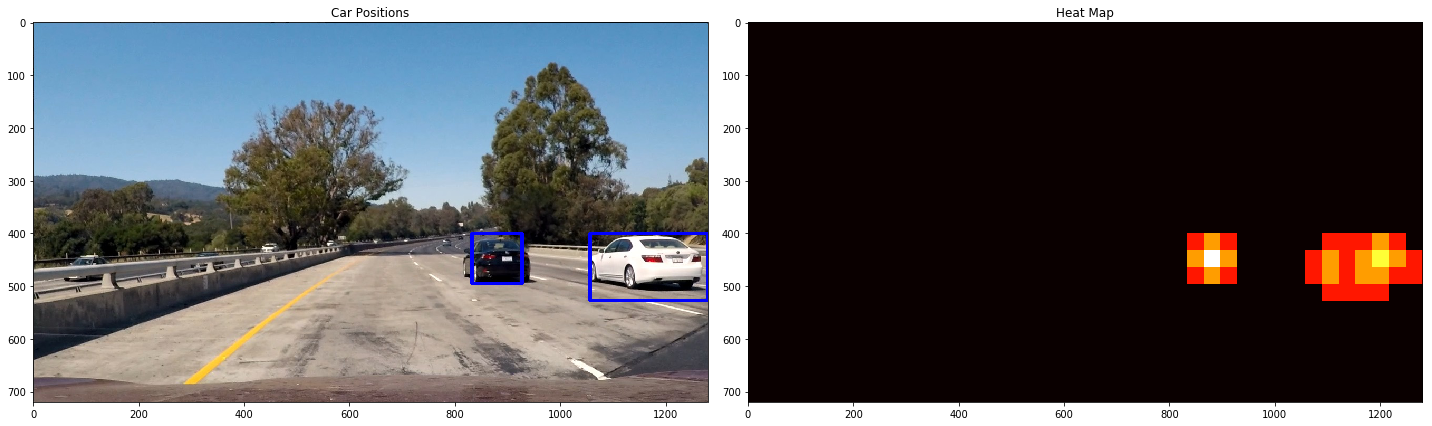

In [11]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.savefig('./examples/heatmap.png', bbox_inches='tight')

# Full car-detection pipeline

In [17]:
import queue
PREV_BOXES = queue.Queue()
LEN_HISTORY = 6
SINGLE_IMG_THRESHOLD = 1

def car_detection_pipeline(img, xgboost_model, X_scaler, orient, pix_per_cell, cell_per_block):
    global PREV_BOXES
    global LEN_HISTORY
    global SINGLE_IMG_THRESHOLD
    
    ystart = 400
    ystop = 656
   
    boxes = []
    for scale in  np.arange(1, 4, 1):    
        out_img, box = find_cars(img, ystart, ystop, scale, xgboost_model, X_scaler, orient, pix_per_cell, cell_per_block)
        boxes.extend(box)

    PREV_BOXES.put(boxes)
    if PREV_BOXES.qsize() > LEN_HISTORY:
        PREV_BOXES.get()
    
    all_boxes = []
    for boxes in PREV_BOXES.queue:
        all_boxes.extend(boxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, all_boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,SINGLE_IMG_THRESHOLD*PREV_BOXES.qsize())

    # Visualize the heatmap when displaying    
    heatmap = heat*255/np.max(heat)
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    heatmap = np.dstack((heatmap, heatmap, heatmap))

    result = np.hstack((draw_img, heatmap))
    return result.astype(np.int32)

In [18]:
result = car_detection_pipeline(img, classifier_model, X_scaler, orient, pix_per_cell, cell_per_block)

Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0


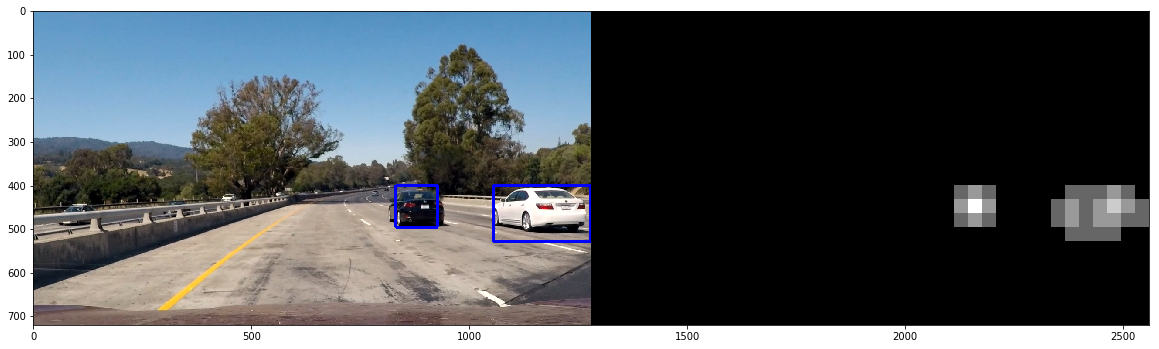

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(result)

# Apply pipeline on video

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

PREV_BOXES = queue.Queue()
white_output = './test_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(lambda img: car_detection_pipeline(img, classifier_model, X_scaler, orient, pix_per_cell, cell_per_block)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0
[MoviePy] >>>> Building video ./test_video_proccessed.mp4
[MoviePy] Writing video ./test_video_proccessed.mp4



  0%|          | 0/39 [00:00<?, ?it/s]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



  3%|▎         | 1/39 [00:05<03:21,  5.31s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



  5%|▌         | 2/39 [00:10<03:12,  5.21s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



  8%|▊         | 3/39 [00:15<03:11,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 10%|█         | 4/39 [00:21<03:06,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 13%|█▎        | 5/39 [00:26<03:00,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 15%|█▌        | 6/39 [00:32<02:56,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 18%|█▊        | 7/39 [00:37<02:52,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 21%|██        | 8/39 [00:42<02:45,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 23%|██▎       | 9/39 [00:48<02:41,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0



 26%|██▌       | 10/39 [00:54<02:37,  5.42s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 28%|██▊       | 11/39 [00:59<02:31,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 31%|███       | 12/39 [01:05<02:26,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 33%|███▎      | 13/39 [01:10<02:21,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 36%|███▌      | 14/39 [01:16<02:15,  5.43s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 38%|███▊      | 15/39 [01:21<02:10,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 41%|████      | 16/39 [01:27<02:05,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 44%|████▎     | 17/39 [01:32<01:59,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 46%|████▌     | 18/39 [01:37<01:54,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 49%|████▊     | 19/39 [01:43<01:49,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 51%|█████▏    | 20/39 [01:48<01:43,  5.44s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 54%|█████▍    | 21/39 [01:54<01:37,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 56%|█████▋    | 22/39 [01:59<01:32,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 1



 59%|█████▉    | 23/39 [02:04<01:26,  5.43s/it]

Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 62%|██████▏   | 24/39 [02:10<01:21,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 64%|██████▍   | 25/39 [02:16<01:16,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 67%|██████▋   | 26/39 [02:21<01:10,  5.45s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 69%|██████▉   | 27/39 [02:27<01:05,  5.45s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 72%|███████▏  | 28/39 [02:32<00:59,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 4



 74%|███████▍  | 29/39 [02:37<00:54,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 77%|███████▋  | 30/39 [02:43<00:48,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 79%|███████▉  | 31/39 [02:48<00:43,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 82%|████████▏ | 32/39 [02:54<00:38,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 85%|████████▍ | 33/39 [02:59<00:32,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 87%|████████▋ | 34/39 [03:04<00:27,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 90%|████████▉ | 35/39 [03:09<00:21,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 92%|█████████▏| 36/39 [03:15<00:16,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0



 95%|█████████▍| 37/39 [03:20<00:10,  5.42s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 97%|█████████▋| 38/39 [03:25<00:05,  5.42s/it]


Windows: 12 Detected cars: 0
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_proccessed.mp4 

CPU times: user 20min 1s, sys: 7.04 s, total: 20min 8s
Wall time: 3min 26s


In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

PREV_BOXES = queue.Queue()
white_output = './project_video_proccessed_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(lambda img: car_detection_pipeline(img, classifier_model, X_scaler, orient, pix_per_cell, cell_per_block)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0
[MoviePy] >>>> Building video ./project_video_proccessed_2.mp4
[MoviePy] Writing video ./project_video_proccessed_2.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  0%|          | 1/1261 [00:05<2:02:08,  5.82s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  0%|          | 2/1261 [00:11<2:00:16,  5.73s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  0%|          | 3/1261 [00:16<1:56:04,  5.54s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  0%|          | 4/1261 [00:22<1:57:13,  5.60s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  0%|          | 5/1261 [00:27<1:56:53,  5.58s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  0%|          | 6/1261 [00:33<1:56:01,  5.55s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 7/1261 [00:38<1:56:25,  5.57s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 8/1261 [00:44<1:56:23,  5.57s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 9/1261 [00:49<1:55:20,  5.53s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 10/1261 [00:55<1:55:09,  5.52s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 11/1261 [01:00<1:54:45,  5.51s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 12/1261 [01:05<1:53:54,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 13/1261 [01:11<1:53:51,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  1%|          | 14/1261 [01:16<1:53:39,  5.47s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|          | 15/1261 [01:21<1:53:17,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|▏         | 16/1261 [01:27<1:53:19,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|▏         | 17/1261 [01:33<1:53:27,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  1%|▏         | 18/1261 [01:38<1:53:06,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 19/1261 [01:43<1:53:02,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 20/1261 [01:49<1:52:59,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 21/1261 [01:54<1:52:35,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 22/1261 [01:59<1:52:32,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 23/1261 [02:05<1:52:29,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 24/1261 [02:10<1:52:13,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 25/1261 [02:16<1:52:08,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 26/1261 [02:21<1:52:07,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 27/1261 [02:26<1:51:47,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 28/1261 [02:32<1:51:46,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 29/1261 [02:38<1:51:52,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 30/1261 [02:43<1:51:40,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  2%|▏         | 31/1261 [02:48<1:51:39,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 32/1261 [02:54<1:51:33,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  3%|▎         | 33/1261 [02:59<1:51:16,  5.44s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 34/1261 [03:04<1:51:14,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 35/1261 [03:10<1:51:07,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  3%|▎         | 36/1261 [03:15<1:50:55,  5.43s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 37/1261 [03:21<1:50:49,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 38/1261 [03:26<1:50:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 39/1261 [03:32<1:50:50,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 40/1261 [03:37<1:50:45,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 41/1261 [03:43<1:50:47,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 42/1261 [03:49<1:50:50,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 43/1261 [03:54<1:50:43,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  3%|▎         | 44/1261 [04:00<1:50:42,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▎         | 45/1261 [04:05<1:50:36,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▎         | 46/1261 [04:10<1:50:27,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▎         | 47/1261 [04:16<1:50:31,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 48/1261 [04:22<1:50:35,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 49/1261 [04:27<1:50:26,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 50/1261 [04:33<1:50:22,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 51/1261 [04:39<1:50:22,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 52/1261 [04:44<1:50:15,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 53/1261 [04:50<1:50:14,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 54/1261 [04:55<1:50:08,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 55/1261 [05:00<1:49:59,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  4%|▍         | 56/1261 [05:06<1:49:56,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 57/1261 [05:11<1:49:49,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 58/1261 [05:17<1:49:35,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 59/1261 [05:22<1:49:31,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 60/1261 [05:28<1:49:27,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 61/1261 [05:33<1:49:16,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 62/1261 [05:38<1:49:15,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▍         | 63/1261 [05:44<1:49:16,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 64/1261 [05:50<1:49:06,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 65/1261 [05:55<1:49:02,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 66/1261 [06:01<1:49:03,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 67/1261 [06:06<1:48:51,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 68/1261 [06:12<1:48:50,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  5%|▌         | 69/1261 [06:17<1:48:48,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  6%|▌         | 70/1261 [06:23<1:48:36,  5.47s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 71/1261 [06:28<1:48:36,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 72/1261 [06:34<1:48:36,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  6%|▌         | 73/1261 [06:40<1:48:32,  5.48s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 74/1261 [06:45<1:48:27,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 75/1261 [06:51<1:48:23,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 76/1261 [06:56<1:48:15,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  6%|▌         | 77/1261 [07:02<1:48:11,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▌         | 78/1261 [07:07<1:48:06,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▋         | 79/1261 [07:12<1:47:58,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▋         | 80/1261 [07:18<1:47:51,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  6%|▋         | 81/1261 [07:23<1:47:46,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  7%|▋         | 82/1261 [07:29<1:47:38,  5.48s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 83/1261 [07:34<1:47:28,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 84/1261 [07:39<1:47:24,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 85/1261 [07:45<1:47:18,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 86/1261 [07:50<1:47:11,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 87/1261 [07:56<1:47:07,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 88/1261 [08:01<1:47:02,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 89/1261 [08:07<1:46:56,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 90/1261 [08:13<1:46:55,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 91/1261 [08:18<1:46:49,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 92/1261 [08:23<1:46:39,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 93/1261 [08:29<1:46:34,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  7%|▋         | 94/1261 [08:34<1:46:30,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 95/1261 [08:39<1:46:20,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 96/1261 [08:45<1:46:14,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  8%|▊         | 97/1261 [08:50<1:46:08,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  8%|▊         | 98/1261 [08:55<1:45:58,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  8%|▊         | 99/1261 [09:01<1:45:53,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  8%|▊         | 100/1261 [09:06<1:45:47,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 101/1261 [09:11<1:45:37,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 102/1261 [09:17<1:45:33,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 103/1261 [09:23<1:45:29,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 104/1261 [09:28<1:45:23,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 105/1261 [09:34<1:45:20,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  8%|▊         | 106/1261 [09:39<1:45:16,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  8%|▊         | 107/1261 [09:45<1:45:09,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▊         | 108/1261 [09:50<1:45:06,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▊         | 109/1261 [09:56<1:45:01,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▊         | 110/1261 [10:01<1:44:53,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  9%|▉         | 111/1261 [10:06<1:44:48,  5.47s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▉         | 112/1261 [10:12<1:44:41,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



  9%|▉         | 113/1261 [10:17<1:44:32,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▉         | 114/1261 [10:22<1:44:26,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



  9%|▉         | 115/1261 [10:28<1:44:23,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  9%|▉         | 116/1261 [10:33<1:44:16,  5.46s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



  9%|▉         | 117/1261 [10:39<1:44:11,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



  9%|▉         | 118/1261 [10:44<1:44:06,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



  9%|▉         | 119/1261 [10:50<1:44:00,  5.46s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 10%|▉         | 120/1261 [10:55<1:43:56,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 10%|▉         | 121/1261 [11:01<1:43:51,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 10%|▉         | 122/1261 [11:06<1:43:45,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|▉         | 123/1261 [11:12<1:43:39,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|▉         | 124/1261 [11:17<1:43:33,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 10%|▉         | 125/1261 [11:23<1:43:27,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|▉         | 126/1261 [11:28<1:43:21,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|█         | 127/1261 [11:33<1:43:15,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|█         | 128/1261 [11:39<1:43:09,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 10%|█         | 129/1261 [11:44<1:43:01,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 10%|█         | 130/1261 [11:49<1:42:56,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 10%|█         | 131/1261 [11:55<1:42:50,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 10%|█         | 132/1261 [12:00<1:42:42,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 11%|█         | 133/1261 [12:05<1:42:37,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█         | 134/1261 [12:11<1:42:30,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 11%|█         | 135/1261 [12:16<1:42:22,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 11%|█         | 136/1261 [12:21<1:42:16,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█         | 137/1261 [12:27<1:42:10,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 11%|█         | 138/1261 [12:32<1:42:02,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█         | 139/1261 [12:37<1:41:57,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 11%|█         | 140/1261 [12:43<1:41:51,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█         | 141/1261 [12:48<1:41:43,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 11%|█▏        | 142/1261 [12:54<1:41:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█▏        | 143/1261 [12:59<1:41:37,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 11%|█▏        | 144/1261 [13:05<1:41:31,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 11%|█▏        | 145/1261 [13:10<1:41:26,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 12%|█▏        | 146/1261 [13:16<1:41:22,  5.46s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 12%|█▏        | 147/1261 [13:21<1:41:15,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 12%|█▏        | 148/1261 [13:27<1:41:11,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 12%|█▏        | 149/1261 [13:32<1:41:06,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 12%|█▏        | 150/1261 [13:37<1:40:58,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 12%|█▏        | 151/1261 [13:43<1:40:53,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 12%|█▏        | 152/1261 [13:48<1:40:48,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 12%|█▏        | 153/1261 [13:54<1:40:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 12%|█▏        | 154/1261 [13:59<1:40:35,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 12%|█▏        | 155/1261 [14:05<1:40:30,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 12%|█▏        | 156/1261 [14:10<1:40:24,  5.45s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 12%|█▏        | 157/1261 [14:16<1:40:20,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 13%|█▎        | 158/1261 [14:21<1:40:15,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 13%|█▎        | 159/1261 [14:26<1:40:08,  5.45s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 13%|█▎        | 160/1261 [14:32<1:40:02,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 13%|█▎        | 161/1261 [14:37<1:39:58,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 13%|█▎        | 162/1261 [14:43<1:39:51,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 13%|█▎        | 163/1261 [14:48<1:39:46,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 13%|█▎        | 164/1261 [14:54<1:39:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 13%|█▎        | 165/1261 [14:59<1:39:34,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 13%|█▎        | 166/1261 [15:04<1:39:28,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 13%|█▎        | 167/1261 [15:10<1:39:23,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 13%|█▎        | 168/1261 [15:15<1:39:17,  5.45s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 13%|█▎        | 169/1261 [15:20<1:39:10,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0


 13%|█▎        | 170/1261 [15:26<1:39:05,  5.45s/it]


Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 14%|█▎        | 171/1261 [15:31<1:38:59,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 14%|█▎        | 172/1261 [15:37<1:38:52,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 14%|█▎        | 173/1261 [15:42<1:38:47,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 14%|█▍        | 174/1261 [15:47<1:38:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 14%|█▍        | 175/1261 [15:53<1:38:34,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 14%|█▍        | 176/1261 [15:58<1:38:29,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 14%|█▍        | 177/1261 [16:03<1:38:23,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 14%|█▍        | 178/1261 [16:09<1:38:16,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 14%|█▍        | 179/1261 [16:14<1:38:10,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 14%|█▍        | 180/1261 [16:20<1:38:06,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 14%|█▍        | 181/1261 [16:25<1:37:59,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 14%|█▍        | 182/1261 [16:30<1:37:54,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 15%|█▍        | 183/1261 [16:36<1:37:48,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 15%|█▍        | 184/1261 [16:41<1:37:41,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 15%|█▍        | 185/1261 [16:46<1:37:36,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 15%|█▍        | 186/1261 [16:52<1:37:30,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 15%|█▍        | 187/1261 [16:57<1:37:23,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 15%|█▍        | 188/1261 [17:02<1:37:17,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 15%|█▍        | 189/1261 [17:08<1:37:12,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 15%|█▌        | 190/1261 [17:13<1:37:05,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 15%|█▌        | 191/1261 [17:19<1:37:01,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 15%|█▌        | 192/1261 [17:24<1:36:56,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 15%|█▌        | 193/1261 [17:29<1:36:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 15%|█▌        | 194/1261 [17:35<1:36:44,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 15%|█▌        | 195/1261 [17:40<1:36:38,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 16%|█▌        | 196/1261 [17:45<1:36:31,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 16%|█▌        | 197/1261 [17:51<1:36:27,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 16%|█▌        | 198/1261 [17:57<1:36:23,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 16%|█▌        | 199/1261 [18:02<1:36:16,  5.44s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 16%|█▌        | 200/1261 [18:07<1:36:11,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 16%|█▌        | 201/1261 [18:13<1:36:07,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 16%|█▌        | 202/1261 [18:18<1:36:01,  5.44s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 16%|█▌        | 203/1261 [18:24<1:35:55,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 16%|█▌        | 204/1261 [18:29<1:35:50,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 16%|█▋        | 205/1261 [18:35<1:35:44,  5.44s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 16%|█▋        | 206/1261 [18:40<1:35:39,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 16%|█▋        | 207/1261 [18:46<1:35:35,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 16%|█▋        | 208/1261 [18:52<1:35:30,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 17%|█▋        | 209/1261 [18:57<1:35:24,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 17%|█▋        | 210/1261 [19:02<1:35:20,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 17%|█▋        | 211/1261 [19:08<1:35:14,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 17%|█▋        | 212/1261 [19:13<1:35:08,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 17%|█▋        | 213/1261 [19:19<1:35:03,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 17%|█▋        | 214/1261 [19:24<1:34:59,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 17%|█▋        | 215/1261 [19:30<1:34:55,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 17%|█▋        | 216/1261 [19:36<1:34:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 17%|█▋        | 217/1261 [19:41<1:34:44,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 17%|█▋        | 218/1261 [19:46<1:34:37,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 17%|█▋        | 219/1261 [19:52<1:34:32,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 17%|█▋        | 220/1261 [19:57<1:34:28,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 221/1261 [20:03<1:34:22,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 222/1261 [20:08<1:34:17,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 223/1261 [20:14<1:34:12,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 18%|█▊        | 224/1261 [20:19<1:34:06,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 225/1261 [20:25<1:34:01,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 18%|█▊        | 226/1261 [20:30<1:33:56,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 227/1261 [20:35<1:33:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 228/1261 [20:41<1:33:46,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 18%|█▊        | 229/1261 [20:47<1:33:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 230/1261 [20:52<1:33:34,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 18%|█▊        | 231/1261 [20:58<1:33:30,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 18%|█▊        | 232/1261 [21:03<1:33:26,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 18%|█▊        | 233/1261 [21:09<1:33:19,  5.45s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 19%|█▊        | 234/1261 [21:14<1:33:14,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 19%|█▊        | 235/1261 [21:20<1:33:08,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 19%|█▊        | 236/1261 [21:25<1:33:02,  5.45s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 19%|█▉        | 237/1261 [21:31<1:32:58,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 19%|█▉        | 238/1261 [21:36<1:32:53,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 19%|█▉        | 239/1261 [21:42<1:32:48,  5.45s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 19%|█▉        | 240/1261 [21:47<1:32:42,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 19%|█▉        | 241/1261 [21:53<1:32:38,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 19%|█▉        | 242/1261 [21:59<1:32:34,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 19%|█▉        | 243/1261 [22:04<1:32:28,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 19%|█▉        | 244/1261 [22:10<1:32:25,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 19%|█▉        | 245/1261 [22:15<1:32:20,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 20%|█▉        | 246/1261 [22:21<1:32:13,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 20%|█▉        | 247/1261 [22:26<1:32:09,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 20%|█▉        | 248/1261 [22:32<1:32:03,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 20%|█▉        | 249/1261 [22:37<1:31:57,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 20%|█▉        | 250/1261 [22:43<1:31:52,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 20%|█▉        | 251/1261 [22:48<1:31:46,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 20%|█▉        | 252/1261 [22:53<1:31:40,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 20%|██        | 253/1261 [22:59<1:31:35,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 20%|██        | 254/1261 [23:04<1:31:30,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 20%|██        | 255/1261 [23:11<1:31:30,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 20%|██        | 256/1261 [23:18<1:31:32,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 20%|██        | 257/1261 [23:24<1:31:28,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 20%|██        | 258/1261 [23:30<1:31:21,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 21%|██        | 259/1261 [23:35<1:31:17,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 21%|██        | 260/1261 [23:42<1:31:14,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 21%|██        | 261/1261 [23:47<1:31:09,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 21%|██        | 262/1261 [23:53<1:31:04,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 21%|██        | 263/1261 [23:58<1:30:58,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 21%|██        | 264/1261 [24:03<1:30:52,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 21%|██        | 265/1261 [24:10<1:30:49,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 21%|██        | 266/1261 [24:16<1:30:48,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 21%|██        | 267/1261 [24:22<1:30:44,  5.48s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 21%|██▏       | 268/1261 [24:29<1:30:43,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 21%|██▏       | 269/1261 [24:35<1:30:39,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 21%|██▏       | 270/1261 [24:40<1:30:34,  5.48s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 21%|██▏       | 271/1261 [24:46<1:30:29,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 22%|██▏       | 272/1261 [24:51<1:30:24,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 22%|██▏       | 273/1261 [24:57<1:30:19,  5.49s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 22%|██▏       | 274/1261 [25:03<1:30:15,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 22%|██▏       | 275/1261 [25:09<1:30:11,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 22%|██▏       | 276/1261 [25:14<1:30:05,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 22%|██▏       | 277/1261 [25:20<1:30:00,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 22%|██▏       | 278/1261 [25:25<1:29:55,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 22%|██▏       | 279/1261 [25:31<1:29:50,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 22%|██▏       | 280/1261 [25:36<1:29:44,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 22%|██▏       | 281/1261 [25:42<1:29:38,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 22%|██▏       | 282/1261 [25:47<1:29:32,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 22%|██▏       | 283/1261 [25:52<1:29:25,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 23%|██▎       | 284/1261 [25:58<1:29:21,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 23%|██▎       | 285/1261 [26:04<1:29:16,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 23%|██▎       | 286/1261 [26:09<1:29:09,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 23%|██▎       | 287/1261 [26:14<1:29:04,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 23%|██▎       | 288/1261 [26:20<1:28:58,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 23%|██▎       | 289/1261 [26:25<1:28:51,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 23%|██▎       | 290/1261 [26:30<1:28:46,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 2



 23%|██▎       | 291/1261 [26:36<1:28:42,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 23%|██▎       | 292/1261 [26:41<1:28:35,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 2



 23%|██▎       | 293/1261 [26:47<1:28:30,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 23%|██▎       | 294/1261 [26:53<1:28:26,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 23%|██▎       | 295/1261 [26:58<1:28:20,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 23%|██▎       | 296/1261 [27:04<1:28:16,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 24%|██▎       | 297/1261 [27:10<1:28:11,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 24%|██▎       | 298/1261 [27:15<1:28:05,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 24%|██▎       | 299/1261 [27:21<1:27:59,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 24%|██▍       | 300/1261 [27:26<1:27:54,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 24%|██▍       | 301/1261 [27:31<1:27:48,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 24%|██▍       | 302/1261 [27:37<1:27:42,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 24%|██▍       | 303/1261 [27:42<1:27:37,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 24%|██▍       | 304/1261 [27:47<1:27:30,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 24%|██▍       | 305/1261 [27:53<1:27:25,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 24%|██▍       | 306/1261 [27:58<1:27:19,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 24%|██▍       | 307/1261 [28:03<1:27:12,  5.49s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 24%|██▍       | 308/1261 [28:09<1:27:06,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▍       | 309/1261 [28:14<1:27:01,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 25%|██▍       | 310/1261 [28:20<1:26:55,  5.48s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▍       | 311/1261 [28:25<1:26:50,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 25%|██▍       | 312/1261 [28:31<1:26:45,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 3



 25%|██▍       | 313/1261 [28:36<1:26:39,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 25%|██▍       | 314/1261 [28:42<1:26:34,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▍       | 315/1261 [28:48<1:26:29,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 25%|██▌       | 316/1261 [28:53<1:26:23,  5.49s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 25%|██▌       | 317/1261 [28:58<1:26:17,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▌       | 318/1261 [29:03<1:26:10,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 25%|██▌       | 319/1261 [29:08<1:26:04,  5.48s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▌       | 320/1261 [29:13<1:25:57,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 25%|██▌       | 321/1261 [29:19<1:25:51,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 26%|██▌       | 322/1261 [29:24<1:25:45,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 26%|██▌       | 323/1261 [29:29<1:25:38,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 26%|██▌       | 324/1261 [29:34<1:25:32,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 26%|██▌       | 325/1261 [29:40<1:25:26,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 26%|██▌       | 326/1261 [29:45<1:25:19,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 26%|██▌       | 327/1261 [29:50<1:25:13,  5.48s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 26%|██▌       | 328/1261 [29:55<1:25:07,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 26%|██▌       | 329/1261 [30:00<1:25:00,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 26%|██▌       | 330/1261 [30:05<1:24:54,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 26%|██▌       | 331/1261 [30:11<1:24:48,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 26%|██▋       | 332/1261 [30:16<1:24:41,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 26%|██▋       | 333/1261 [30:21<1:24:35,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 26%|██▋       | 334/1261 [30:26<1:24:29,  5.47s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 27%|██▋       | 335/1261 [30:31<1:24:23,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 27%|██▋       | 336/1261 [30:37<1:24:17,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 27%|██▋       | 337/1261 [30:42<1:24:11,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 27%|██▋       | 338/1261 [30:47<1:24:04,  5.47s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 27%|██▋       | 339/1261 [30:52<1:23:58,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 27%|██▋       | 340/1261 [30:57<1:23:52,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 27%|██▋       | 341/1261 [31:02<1:23:45,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 27%|██▋       | 342/1261 [31:08<1:23:40,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 27%|██▋       | 343/1261 [31:13<1:23:34,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 27%|██▋       | 344/1261 [31:18<1:23:27,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 27%|██▋       | 345/1261 [31:23<1:23:21,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 27%|██▋       | 346/1261 [31:29<1:23:15,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 28%|██▊       | 347/1261 [31:34<1:23:09,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 348/1261 [31:39<1:23:03,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 28%|██▊       | 349/1261 [31:44<1:22:57,  5.46s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 350/1261 [31:49<1:22:50,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 351/1261 [31:54<1:22:44,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 352/1261 [32:00<1:22:38,  5.46s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 353/1261 [32:05<1:22:32,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 28%|██▊       | 354/1261 [32:10<1:22:26,  5.45s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 355/1261 [32:15<1:22:20,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 28%|██▊       | 356/1261 [32:20<1:22:13,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 28%|██▊       | 357/1261 [32:26<1:22:08,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 28%|██▊       | 358/1261 [32:31<1:22:02,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 28%|██▊       | 359/1261 [32:36<1:21:56,  5.45s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▊       | 360/1261 [32:42<1:21:50,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 29%|██▊       | 361/1261 [32:47<1:21:44,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 29%|██▊       | 362/1261 [32:52<1:21:37,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▉       | 363/1261 [32:57<1:21:32,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▉       | 364/1261 [33:02<1:21:26,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 29%|██▉       | 365/1261 [33:07<1:21:19,  5.45s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▉       | 366/1261 [33:13<1:21:13,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▉       | 367/1261 [33:18<1:21:07,  5.45s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 29%|██▉       | 368/1261 [33:23<1:21:01,  5.44s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 29%|██▉       | 369/1261 [33:28<1:20:55,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 29%|██▉       | 370/1261 [33:33<1:20:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 29%|██▉       | 371/1261 [33:38<1:20:43,  5.44s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 30%|██▉       | 372/1261 [33:43<1:20:36,  5.44s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 30%|██▉       | 373/1261 [33:49<1:20:31,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 30%|██▉       | 374/1261 [33:54<1:20:25,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 30%|██▉       | 375/1261 [33:59<1:20:19,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 30%|██▉       | 376/1261 [34:05<1:20:14,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 30%|██▉       | 377/1261 [34:10<1:20:08,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 30%|██▉       | 378/1261 [34:15<1:20:01,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 30%|███       | 379/1261 [34:20<1:19:55,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 30%|███       | 380/1261 [34:25<1:19:49,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 30%|███       | 381/1261 [34:30<1:19:43,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 30%|███       | 382/1261 [34:36<1:19:37,  5.44s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 30%|███       | 383/1261 [34:41<1:19:31,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 30%|███       | 384/1261 [34:46<1:19:25,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 31%|███       | 385/1261 [34:51<1:19:19,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 386/1261 [34:56<1:19:13,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 387/1261 [35:01<1:19:07,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 388/1261 [35:07<1:19:01,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 31%|███       | 389/1261 [35:12<1:18:55,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 390/1261 [35:17<1:18:49,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 31%|███       | 391/1261 [35:22<1:18:43,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 392/1261 [35:28<1:18:38,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 393/1261 [35:33<1:18:31,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 31%|███       | 394/1261 [35:38<1:18:25,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 31%|███▏      | 395/1261 [35:43<1:18:19,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 31%|███▏      | 396/1261 [35:48<1:18:13,  5.43s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 31%|███▏      | 397/1261 [35:54<1:18:07,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 32%|███▏      | 398/1261 [35:59<1:18:02,  5.43s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 32%|███▏      | 399/1261 [36:04<1:17:55,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 32%|███▏      | 400/1261 [36:09<1:17:49,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 32%|███▏      | 401/1261 [36:14<1:17:44,  5.42s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 32%|███▏      | 402/1261 [36:19<1:17:37,  5.42s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 32%|███▏      | 403/1261 [36:25<1:17:32,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 32%|███▏      | 404/1261 [36:30<1:17:26,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 32%|███▏      | 405/1261 [36:35<1:17:20,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 32%|███▏      | 406/1261 [36:40<1:17:14,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 32%|███▏      | 407/1261 [36:45<1:17:08,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 32%|███▏      | 408/1261 [36:50<1:17:02,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 32%|███▏      | 409/1261 [36:56<1:16:56,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 33%|███▎      | 410/1261 [37:01<1:16:51,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 33%|███▎      | 411/1261 [37:06<1:16:44,  5.42s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 33%|███▎      | 412/1261 [37:11<1:16:39,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 33%|███▎      | 413/1261 [37:17<1:16:33,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 33%|███▎      | 414/1261 [37:22<1:16:27,  5.42s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 33%|███▎      | 415/1261 [37:27<1:16:21,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 33%|███▎      | 416/1261 [37:32<1:16:16,  5.42s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 33%|███▎      | 417/1261 [37:37<1:16:09,  5.41s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 33%|███▎      | 418/1261 [37:43<1:16:03,  5.41s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 33%|███▎      | 419/1261 [37:48<1:15:58,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 33%|███▎      | 420/1261 [37:53<1:15:52,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 33%|███▎      | 421/1261 [37:58<1:15:46,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 33%|███▎      | 422/1261 [38:04<1:15:41,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 34%|███▎      | 423/1261 [38:09<1:15:35,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 0



 34%|███▎      | 424/1261 [38:14<1:15:29,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 0



 34%|███▎      | 425/1261 [38:19<1:15:24,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 34%|███▍      | 426/1261 [38:25<1:15:18,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 34%|███▍      | 427/1261 [38:30<1:15:12,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 428/1261 [38:35<1:15:06,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 429/1261 [38:40<1:15:00,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 34%|███▍      | 430/1261 [38:45<1:14:54,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 431/1261 [38:51<1:14:49,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 432/1261 [38:56<1:14:43,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 34%|███▍      | 433/1261 [39:01<1:14:37,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 434/1261 [39:06<1:14:31,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 34%|███▍      | 435/1261 [39:11<1:14:25,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 35%|███▍      | 436/1261 [39:16<1:14:19,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 35%|███▍      | 437/1261 [39:22<1:14:14,  5.41s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 35%|███▍      | 438/1261 [39:27<1:14:08,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 35%|███▍      | 439/1261 [39:32<1:14:02,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 35%|███▍      | 440/1261 [39:37<1:13:56,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 35%|███▍      | 441/1261 [39:43<1:13:51,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 35%|███▌      | 442/1261 [39:48<1:13:44,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 35%|███▌      | 443/1261 [39:53<1:13:39,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 35%|███▌      | 444/1261 [39:58<1:13:33,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 35%|███▌      | 445/1261 [40:03<1:13:27,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 35%|███▌      | 446/1261 [40:08<1:13:21,  5.40s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 35%|███▌      | 447/1261 [40:13<1:13:15,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▌      | 448/1261 [40:18<1:13:09,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 36%|███▌      | 449/1261 [40:23<1:13:03,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 36%|███▌      | 450/1261 [40:29<1:12:58,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▌      | 451/1261 [40:34<1:12:52,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 36%|███▌      | 452/1261 [40:39<1:12:46,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▌      | 453/1261 [40:45<1:12:41,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 36%|███▌      | 454/1261 [40:49<1:12:34,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▌      | 455/1261 [40:55<1:12:29,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 36%|███▌      | 456/1261 [41:00<1:12:23,  5.40s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▌      | 457/1261 [41:05<1:12:17,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 36%|███▋      | 458/1261 [41:10<1:12:11,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 36%|███▋      | 459/1261 [41:15<1:12:06,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 36%|███▋      | 460/1261 [41:21<1:12:00,  5.39s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 37%|███▋      | 461/1261 [41:26<1:11:54,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 37%|███▋      | 462/1261 [41:31<1:11:49,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 37%|███▋      | 463/1261 [41:36<1:11:43,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 37%|███▋      | 464/1261 [41:42<1:11:37,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 37%|███▋      | 465/1261 [41:47<1:11:32,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 37%|███▋      | 466/1261 [41:52<1:11:26,  5.39s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 37%|███▋      | 467/1261 [41:57<1:11:20,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 37%|███▋      | 468/1261 [42:03<1:11:15,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 37%|███▋      | 469/1261 [42:08<1:11:09,  5.39s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 37%|███▋      | 470/1261 [42:13<1:11:04,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 37%|███▋      | 471/1261 [42:18<1:10:58,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 37%|███▋      | 472/1261 [42:24<1:10:52,  5.39s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 473/1261 [42:29<1:10:47,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 38%|███▊      | 474/1261 [42:34<1:10:41,  5.39s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 475/1261 [42:40<1:10:36,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 38%|███▊      | 476/1261 [42:45<1:10:30,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 477/1261 [42:50<1:10:24,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 478/1261 [42:55<1:10:18,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 479/1261 [43:00<1:10:12,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 38%|███▊      | 480/1261 [43:05<1:10:06,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 481/1261 [43:10<1:10:01,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 482/1261 [43:15<1:09:55,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 38%|███▊      | 483/1261 [43:21<1:09:49,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 484/1261 [43:26<1:09:44,  5.39s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 38%|███▊      | 485/1261 [43:31<1:09:38,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 39%|███▊      | 486/1261 [43:36<1:09:32,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 39%|███▊      | 487/1261 [43:41<1:09:27,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 39%|███▊      | 488/1261 [43:46<1:09:20,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 39%|███▉      | 489/1261 [43:52<1:09:15,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 39%|███▉      | 490/1261 [43:57<1:09:09,  5.38s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 39%|███▉      | 491/1261 [44:02<1:09:03,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 39%|███▉      | 492/1261 [44:07<1:08:58,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 39%|███▉      | 493/1261 [44:12<1:08:52,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 39%|███▉      | 494/1261 [44:17<1:08:46,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 39%|███▉      | 495/1261 [44:23<1:08:40,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 39%|███▉      | 496/1261 [44:28<1:08:35,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 39%|███▉      | 497/1261 [44:33<1:08:29,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 39%|███▉      | 498/1261 [44:38<1:08:24,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 40%|███▉      | 499/1261 [44:44<1:08:18,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 40%|███▉      | 500/1261 [44:49<1:08:12,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 40%|███▉      | 501/1261 [44:54<1:08:07,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 40%|███▉      | 502/1261 [44:59<1:08:01,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 40%|███▉      | 503/1261 [45:04<1:07:55,  5.38s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 40%|███▉      | 504/1261 [45:09<1:07:50,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 40%|████      | 505/1261 [45:15<1:07:44,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 40%|████      | 506/1261 [45:20<1:07:38,  5.38s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 40%|████      | 507/1261 [45:25<1:07:33,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 40%|████      | 508/1261 [45:30<1:07:28,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 40%|████      | 509/1261 [45:36<1:07:22,  5.38s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 40%|████      | 510/1261 [45:41<1:07:16,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 511/1261 [45:46<1:07:11,  5.38s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 41%|████      | 512/1261 [45:51<1:07:05,  5.37s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 513/1261 [45:57<1:07:00,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 514/1261 [46:02<1:06:54,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 515/1261 [46:07<1:06:48,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 516/1261 [46:12<1:06:42,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 517/1261 [46:17<1:06:37,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 41%|████      | 518/1261 [46:23<1:06:31,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 519/1261 [46:28<1:06:26,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████      | 520/1261 [46:33<1:06:20,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 41%|████▏     | 521/1261 [46:38<1:06:15,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 41%|████▏     | 522/1261 [46:43<1:06:09,  5.37s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 41%|████▏     | 523/1261 [46:49<1:06:03,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 42%|████▏     | 524/1261 [46:54<1:05:58,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 42%|████▏     | 525/1261 [46:59<1:05:52,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 42%|████▏     | 526/1261 [47:04<1:05:46,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 42%|████▏     | 527/1261 [47:09<1:05:41,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 42%|████▏     | 528/1261 [47:14<1:05:35,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 42%|████▏     | 529/1261 [47:19<1:05:29,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 42%|████▏     | 530/1261 [47:25<1:05:24,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 2



 42%|████▏     | 531/1261 [47:30<1:05:18,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 42%|████▏     | 532/1261 [47:35<1:05:13,  5.37s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 42%|████▏     | 533/1261 [47:40<1:05:07,  5.37s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 42%|████▏     | 534/1261 [47:45<1:05:01,  5.37s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 42%|████▏     | 535/1261 [47:51<1:04:56,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 43%|████▎     | 536/1261 [47:56<1:04:50,  5.37s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 43%|████▎     | 537/1261 [48:01<1:04:44,  5.37s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 43%|████▎     | 538/1261 [48:06<1:04:39,  5.37s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 3



 43%|████▎     | 539/1261 [48:12<1:04:33,  5.37s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 43%|████▎     | 540/1261 [48:16<1:04:27,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 43%|████▎     | 541/1261 [48:22<1:04:22,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 1



 43%|████▎     | 542/1261 [48:27<1:04:17,  5.36s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 43%|████▎     | 543/1261 [48:32<1:04:11,  5.36s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 2



 43%|████▎     | 544/1261 [48:38<1:04:06,  5.36s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 3



 43%|████▎     | 545/1261 [48:43<1:04:00,  5.36s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 43%|████▎     | 546/1261 [48:48<1:03:54,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 43%|████▎     | 547/1261 [48:53<1:03:49,  5.36s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 1



 43%|████▎     | 548/1261 [48:58<1:03:43,  5.36s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▎     | 549/1261 [49:03<1:03:38,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 44%|████▎     | 550/1261 [49:09<1:03:32,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▎     | 551/1261 [49:14<1:03:27,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 44%|████▍     | 552/1261 [49:19<1:03:21,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1



 44%|████▍     | 553/1261 [49:25<1:03:16,  5.36s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▍     | 554/1261 [49:30<1:03:10,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▍     | 555/1261 [49:35<1:03:05,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 44%|████▍     | 556/1261 [49:40<1:02:59,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 44%|████▍     | 557/1261 [49:46<1:02:54,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▍     | 558/1261 [49:51<1:02:48,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 44%|████▍     | 559/1261 [49:56<1:02:42,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 44%|████▍     | 560/1261 [50:01<1:02:37,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 44%|████▍     | 561/1261 [50:06<1:02:31,  5.36s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 45%|████▍     | 562/1261 [50:11<1:02:26,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 45%|████▍     | 563/1261 [50:17<1:02:20,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 45%|████▍     | 564/1261 [50:22<1:02:15,  5.36s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 45%|████▍     | 565/1261 [50:27<1:02:09,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 45%|████▍     | 566/1261 [50:33<1:02:04,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 45%|████▍     | 567/1261 [50:38<1:01:58,  5.36s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 45%|████▌     | 568/1261 [50:43<1:01:53,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 45%|████▌     | 569/1261 [50:48<1:01:47,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 45%|████▌     | 570/1261 [50:53<1:01:42,  5.36s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 45%|████▌     | 571/1261 [50:59<1:01:36,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 45%|████▌     | 572/1261 [51:04<1:01:31,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 2



 45%|████▌     | 573/1261 [51:09<1:01:25,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 574/1261 [51:14<1:01:20,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 575/1261 [51:20<1:01:14,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 46%|████▌     | 576/1261 [51:25<1:01:09,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 577/1261 [51:30<1:01:03,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 578/1261 [51:36<1:00:58,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 46%|████▌     | 579/1261 [51:41<1:00:52,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 580/1261 [51:46<1:00:47,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▌     | 581/1261 [51:51<1:00:41,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 46%|████▌     | 582/1261 [51:56<1:00:36,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 46%|████▌     | 583/1261 [52:01<1:00:30,  5.36s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 46%|████▋     | 584/1261 [52:07<1:00:25,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 46%|████▋     | 585/1261 [52:12<1:00:19,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 46%|████▋     | 586/1261 [52:17<1:00:13,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 47%|████▋     | 587/1261 [52:22<1:00:08,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 47%|████▋     | 588/1261 [52:27<1:00:02,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 47%|████▋     | 589/1261 [52:32<59:57,  5.35s/it]  

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 47%|████▋     | 590/1261 [52:38<59:51,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 47%|████▋     | 591/1261 [52:43<59:46,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 47%|████▋     | 592/1261 [52:48<59:40,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 47%|████▋     | 593/1261 [52:53<59:35,  5.35s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 47%|████▋     | 594/1261 [52:58<59:29,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 47%|████▋     | 595/1261 [53:03<59:23,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 47%|████▋     | 596/1261 [53:09<59:18,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 47%|████▋     | 597/1261 [53:14<59:12,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 47%|████▋     | 598/1261 [53:19<59:07,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 48%|████▊     | 599/1261 [53:24<59:01,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 48%|████▊     | 600/1261 [53:30<58:56,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 48%|████▊     | 601/1261 [53:35<58:50,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 48%|████▊     | 602/1261 [53:40<58:45,  5.35s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 48%|████▊     | 603/1261 [53:45<58:39,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 48%|████▊     | 604/1261 [53:50<58:34,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 48%|████▊     | 605/1261 [53:55<58:28,  5.35s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 48%|████▊     | 606/1261 [54:01<58:23,  5.35s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 48%|████▊     | 607/1261 [54:06<58:17,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 1



 48%|████▊     | 608/1261 [54:11<58:12,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 48%|████▊     | 609/1261 [54:16<58:06,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 48%|████▊     | 610/1261 [54:21<58:00,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 1



 48%|████▊     | 611/1261 [54:26<57:55,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▊     | 612/1261 [54:32<57:50,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 49%|████▊     | 613/1261 [54:37<57:44,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▊     | 614/1261 [54:42<57:38,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▉     | 615/1261 [54:47<57:33,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▉     | 616/1261 [54:52<57:27,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▉     | 617/1261 [54:58<57:22,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 49%|████▉     | 618/1261 [55:03<57:17,  5.35s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 49%|████▉     | 619/1261 [55:08<57:11,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 49%|████▉     | 620/1261 [55:13<57:06,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 49%|████▉     | 621/1261 [55:19<57:00,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 49%|████▉     | 622/1261 [55:24<56:55,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 49%|████▉     | 623/1261 [55:29<56:49,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 49%|████▉     | 624/1261 [55:34<56:44,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 50%|████▉     | 625/1261 [55:39<56:38,  5.34s/it]

Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 50%|████▉     | 626/1261 [55:45<56:33,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|████▉     | 627/1261 [55:50<56:27,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 50%|████▉     | 628/1261 [55:55<56:22,  5.34s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|████▉     | 629/1261 [56:00<56:16,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|████▉     | 630/1261 [56:05<56:11,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 50%|█████     | 631/1261 [56:10<56:05,  5.34s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|█████     | 632/1261 [56:16<56:00,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|█████     | 633/1261 [56:21<55:54,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|█████     | 634/1261 [56:26<55:49,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|█████     | 635/1261 [56:32<55:43,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 50%|█████     | 636/1261 [56:37<55:38,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 637/1261 [56:42<55:33,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 638/1261 [56:47<55:27,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 0
Windows: 57 Detected cars: 0



 51%|█████     | 639/1261 [56:52<55:22,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 640/1261 [56:58<55:16,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 641/1261 [57:03<55:11,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 642/1261 [57:08<55:05,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 643/1261 [57:13<55:00,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 644/1261 [57:18<54:54,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 51%|█████     | 645/1261 [57:24<54:49,  5.34s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████     | 646/1261 [57:29<54:43,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████▏    | 647/1261 [57:34<54:38,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 51%|█████▏    | 648/1261 [57:39<54:33,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 51%|█████▏    | 649/1261 [57:45<54:27,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 52%|█████▏    | 650/1261 [57:49<54:21,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 52%|█████▏    | 651/1261 [57:55<54:16,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 52%|█████▏    | 652/1261 [58:00<54:10,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 52%|█████▏    | 653/1261 [58:05<54:05,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 654/1261 [58:10<53:59,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 655/1261 [58:16<53:54,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 656/1261 [58:21<53:48,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 657/1261 [58:26<53:43,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 658/1261 [58:31<53:38,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 659/1261 [58:36<53:32,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 52%|█████▏    | 660/1261 [58:41<53:27,  5.34s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 661/1261 [58:47<53:21,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 52%|█████▏    | 662/1261 [58:52<53:16,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 53%|█████▎    | 663/1261 [58:57<53:10,  5.34s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 53%|█████▎    | 664/1261 [59:02<53:05,  5.34s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 53%|█████▎    | 665/1261 [59:07<52:59,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 53%|█████▎    | 666/1261 [59:12<52:54,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 53%|█████▎    | 667/1261 [59:18<52:48,  5.33s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 53%|█████▎    | 668/1261 [59:23<52:43,  5.33s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 53%|█████▎    | 669/1261 [59:28<52:37,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 53%|█████▎    | 670/1261 [59:33<52:32,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 53%|█████▎    | 671/1261 [59:38<52:26,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 53%|█████▎    | 672/1261 [59:44<52:21,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 53%|█████▎    | 673/1261 [59:49<52:16,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 53%|█████▎    | 674/1261 [59:54<52:10,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 54%|█████▎    | 675/1261 [59:59<52:04,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 54%|█████▎    | 676/1261 [1:00:04<51:59,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 54%|█████▎    | 677/1261 [1:00:09<51:53,  5.33s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 54%|█████▍    | 678/1261 [1:00:15<51:48,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 54%|█████▍    | 679/1261 [1:00:20<51:43,  5.33s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 54%|█████▍    | 680/1261 [1:00:25<51:37,  5.33s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 54%|█████▍    | 681/1261 [1:00:30<51:32,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 54%|█████▍    | 682/1261 [1:00:36<51:27,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 54%|█████▍    | 683/1261 [1:00:41<51:21,  5.33s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 54%|█████▍    | 684/1261 [1:00:46<51:16,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 54%|█████▍    | 685/1261 [1:00:52<51:10,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 54%|█████▍    | 686/1261 [1:00:57<51:05,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 54%|█████▍    | 687/1261 [1:01:02<50:59,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0


 55%|█████▍    | 688/1261 [1:01:07<50:54,  5.33s/it]


Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 55%|█████▍    | 689/1261 [1:01:12<50:49,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 55%|█████▍    | 690/1261 [1:01:17<50:43,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 55%|█████▍    | 691/1261 [1:01:23<50:38,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 55%|█████▍    | 692/1261 [1:01:28<50:32,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 55%|█████▍    | 693/1261 [1:01:33<50:27,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 55%|█████▌    | 694/1261 [1:01:39<50:22,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 55%|█████▌    | 695/1261 [1:01:44<50:16,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 55%|█████▌    | 696/1261 [1:01:49<50:11,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 55%|█████▌    | 697/1261 [1:01:54<50:05,  5.33s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 55%|█████▌    | 698/1261 [1:01:59<50:00,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 1



 55%|█████▌    | 699/1261 [1:02:04<49:54,  5.33s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 56%|█████▌    | 700/1261 [1:02:09<49:49,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 56%|█████▌    | 701/1261 [1:02:15<49:43,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 56%|█████▌    | 702/1261 [1:02:19<49:38,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 56%|█████▌    | 703/1261 [1:02:25<49:32,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 56%|█████▌    | 704/1261 [1:02:30<49:27,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 56%|█████▌    | 705/1261 [1:02:35<49:21,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 56%|█████▌    | 706/1261 [1:02:40<49:16,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 56%|█████▌    | 707/1261 [1:02:46<49:11,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 56%|█████▌    | 708/1261 [1:02:50<49:05,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 2



 56%|█████▌    | 709/1261 [1:02:56<48:59,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 56%|█████▋    | 710/1261 [1:03:01<48:54,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 4



 56%|█████▋    | 711/1261 [1:03:06<48:48,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 56%|█████▋    | 712/1261 [1:03:11<48:43,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 57%|█████▋    | 713/1261 [1:03:17<48:38,  5.33s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 57%|█████▋    | 714/1261 [1:03:22<48:32,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 57%|█████▋    | 715/1261 [1:03:27<48:27,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 1



 57%|█████▋    | 716/1261 [1:03:32<48:22,  5.32s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 5



 57%|█████▋    | 717/1261 [1:03:37<48:16,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 6



 57%|█████▋    | 718/1261 [1:03:42<48:11,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 15
Windows: 57 Detected cars: 5



 57%|█████▋    | 719/1261 [1:03:48<48:05,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 57%|█████▋    | 720/1261 [1:03:53<48:00,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 57%|█████▋    | 721/1261 [1:03:58<47:54,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 57%|█████▋    | 722/1261 [1:04:03<47:49,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 2



 57%|█████▋    | 723/1261 [1:04:08<47:43,  5.32s/it]

Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 57%|█████▋    | 724/1261 [1:04:14<47:38,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3



 57%|█████▋    | 725/1261 [1:04:19<47:33,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 2



 58%|█████▊    | 726/1261 [1:04:24<47:27,  5.32s/it]

Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 4



 58%|█████▊    | 727/1261 [1:04:29<47:22,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 16
Windows: 57 Detected cars: 5



 58%|█████▊    | 728/1261 [1:04:35<47:17,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 15
Windows: 57 Detected cars: 5



 58%|█████▊    | 729/1261 [1:04:40<47:11,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 5
Windows: 12 Detected cars: 2



 58%|█████▊    | 730/1261 [1:04:45<47:06,  5.32s/it]

Windows: 273 Detected cars: 15
Windows: 57 Detected cars: 5
Windows: 12 Detected cars: 2



 58%|█████▊    | 731/1261 [1:04:50<47:00,  5.32s/it]

Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 6



 58%|█████▊    | 732/1261 [1:04:55<46:55,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 16
Windows: 57 Detected cars: 6



 58%|█████▊    | 733/1261 [1:05:01<46:50,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 15
Windows: 57 Detected cars: 6



 58%|█████▊    | 734/1261 [1:05:06<46:44,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 6



 58%|█████▊    | 735/1261 [1:05:11<46:39,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 6



 58%|█████▊    | 736/1261 [1:05:16<46:33,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 5



 58%|█████▊    | 737/1261 [1:05:21<46:28,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 17
Windows: 57 Detected cars: 5



 59%|█████▊    | 738/1261 [1:05:27<46:23,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 16
Windows: 57 Detected cars: 5



 59%|█████▊    | 739/1261 [1:05:32<46:17,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 18
Windows: 57 Detected cars: 5



 59%|█████▊    | 740/1261 [1:05:37<46:12,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 16
Windows: 57 Detected cars: 5



 59%|█████▉    | 741/1261 [1:05:42<46:06,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 4



 59%|█████▉    | 742/1261 [1:05:47<46:01,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 5



 59%|█████▉    | 743/1261 [1:05:53<45:56,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 15
Windows: 57 Detected cars: 5



 59%|█████▉    | 744/1261 [1:05:58<45:50,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 4



 59%|█████▉    | 745/1261 [1:06:03<45:45,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 59%|█████▉    | 746/1261 [1:06:08<45:39,  5.32s/it]

Windows: 12 Detected cars: 3
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 59%|█████▉    | 747/1261 [1:06:14<45:34,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 59%|█████▉    | 748/1261 [1:06:19<45:28,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 59%|█████▉    | 749/1261 [1:06:24<45:23,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 59%|█████▉    | 750/1261 [1:06:29<45:18,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 60%|█████▉    | 751/1261 [1:06:34<45:12,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 60%|█████▉    | 752/1261 [1:06:39<45:07,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 60%|█████▉    | 753/1261 [1:06:45<45:01,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 60%|█████▉    | 754/1261 [1:06:50<44:56,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 60%|█████▉    | 755/1261 [1:06:55<44:51,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 60%|█████▉    | 756/1261 [1:07:00<44:45,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 2



 60%|██████    | 757/1261 [1:07:05<44:40,  5.32s/it]

Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3



 60%|██████    | 758/1261 [1:07:11<44:34,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 60%|██████    | 759/1261 [1:07:16<44:29,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 60%|██████    | 760/1261 [1:07:21<44:23,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 60%|██████    | 761/1261 [1:07:26<44:18,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 60%|██████    | 762/1261 [1:07:31<44:13,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 61%|██████    | 763/1261 [1:07:36<44:07,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 4



 61%|██████    | 764/1261 [1:07:42<44:02,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 4



 61%|██████    | 765/1261 [1:07:47<43:57,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 61%|██████    | 766/1261 [1:07:52<43:51,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 61%|██████    | 767/1261 [1:07:57<43:46,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 61%|██████    | 768/1261 [1:08:02<43:40,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 61%|██████    | 769/1261 [1:08:07<43:35,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 61%|██████    | 770/1261 [1:08:13<43:30,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 1



 61%|██████    | 771/1261 [1:08:18<43:24,  5.32s/it]

Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 61%|██████    | 772/1261 [1:08:23<43:19,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 61%|██████▏   | 773/1261 [1:08:28<43:13,  5.32s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 61%|██████▏   | 774/1261 [1:08:34<43:08,  5.32s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 61%|██████▏   | 775/1261 [1:08:39<43:03,  5.32s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 776/1261 [1:08:44<42:57,  5.32s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 62%|██████▏   | 777/1261 [1:08:49<42:52,  5.32s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 778/1261 [1:08:54<42:46,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 779/1261 [1:09:00<42:41,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 62%|██████▏   | 780/1261 [1:09:05<42:36,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 781/1261 [1:09:10<42:30,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 782/1261 [1:09:15<42:25,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 62%|██████▏   | 783/1261 [1:09:20<42:20,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 1



 62%|██████▏   | 784/1261 [1:09:25<42:14,  5.31s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 62%|██████▏   | 785/1261 [1:09:31<42:09,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 62%|██████▏   | 786/1261 [1:09:36<42:03,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 1



 62%|██████▏   | 787/1261 [1:09:41<41:58,  5.31s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 62%|██████▏   | 788/1261 [1:09:46<41:53,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 63%|██████▎   | 789/1261 [1:09:51<41:47,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 63%|██████▎   | 790/1261 [1:09:57<41:42,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 63%|██████▎   | 791/1261 [1:10:02<41:36,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 63%|██████▎   | 792/1261 [1:10:07<41:31,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 63%|██████▎   | 793/1261 [1:10:12<41:26,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 63%|██████▎   | 794/1261 [1:10:17<41:20,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 63%|██████▎   | 795/1261 [1:10:22<41:15,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 1



 63%|██████▎   | 796/1261 [1:10:28<41:09,  5.31s/it]

Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 63%|██████▎   | 797/1261 [1:10:33<41:04,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2



 63%|██████▎   | 798/1261 [1:10:38<40:59,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 63%|██████▎   | 799/1261 [1:10:43<40:53,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 63%|██████▎   | 800/1261 [1:10:48<40:48,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 64%|██████▎   | 801/1261 [1:10:54<40:43,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 64%|██████▎   | 802/1261 [1:10:59<40:37,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▎   | 803/1261 [1:11:04<40:32,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 64%|██████▍   | 804/1261 [1:11:09<40:26,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▍   | 805/1261 [1:11:14<40:21,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 64%|██████▍   | 806/1261 [1:11:19<40:15,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▍   | 807/1261 [1:11:25<40:10,  5.31s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 64%|██████▍   | 808/1261 [1:11:30<40:05,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▍   | 809/1261 [1:11:35<39:59,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▍   | 810/1261 [1:11:40<39:54,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 64%|██████▍   | 811/1261 [1:11:45<39:49,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 64%|██████▍   | 812/1261 [1:11:50<39:43,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 64%|██████▍   | 813/1261 [1:11:56<39:38,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 65%|██████▍   | 814/1261 [1:12:01<39:33,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 65%|██████▍   | 815/1261 [1:12:06<39:27,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 65%|██████▍   | 816/1261 [1:12:11<39:22,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 65%|██████▍   | 817/1261 [1:12:16<39:16,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 65%|██████▍   | 818/1261 [1:12:21<39:11,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 65%|██████▍   | 819/1261 [1:12:26<39:05,  5.31s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 65%|██████▌   | 820/1261 [1:12:32<39:00,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 65%|██████▌   | 821/1261 [1:12:37<38:55,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 65%|██████▌   | 822/1261 [1:12:42<38:49,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 65%|██████▌   | 823/1261 [1:12:47<38:44,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 65%|██████▌   | 824/1261 [1:12:52<38:39,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 65%|██████▌   | 825/1261 [1:12:58<38:33,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 66%|██████▌   | 826/1261 [1:13:03<38:28,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 66%|██████▌   | 827/1261 [1:13:08<38:23,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 66%|██████▌   | 828/1261 [1:13:13<38:17,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 66%|██████▌   | 829/1261 [1:13:19<38:12,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 66%|██████▌   | 830/1261 [1:13:24<38:07,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 66%|██████▌   | 831/1261 [1:13:29<38:01,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 66%|██████▌   | 832/1261 [1:13:34<37:56,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 66%|██████▌   | 833/1261 [1:13:40<37:51,  5.31s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 66%|██████▌   | 834/1261 [1:13:45<37:45,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 66%|██████▌   | 835/1261 [1:13:50<37:40,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 66%|██████▋   | 836/1261 [1:13:55<37:35,  5.31s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 66%|██████▋   | 837/1261 [1:14:01<37:29,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 66%|██████▋   | 838/1261 [1:14:06<37:24,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 67%|██████▋   | 839/1261 [1:14:11<37:19,  5.31s/it]

Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 67%|██████▋   | 840/1261 [1:14:16<37:13,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 67%|██████▋   | 841/1261 [1:14:22<37:08,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 67%|██████▋   | 842/1261 [1:14:27<37:03,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 67%|██████▋   | 843/1261 [1:14:32<36:57,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 67%|██████▋   | 844/1261 [1:14:38<36:52,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 67%|██████▋   | 845/1261 [1:14:43<36:47,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 67%|██████▋   | 846/1261 [1:14:48<36:41,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 67%|██████▋   | 847/1261 [1:14:53<36:36,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 67%|██████▋   | 848/1261 [1:14:58<36:31,  5.31s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 67%|██████▋   | 849/1261 [1:15:03<36:25,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 2



 67%|██████▋   | 850/1261 [1:15:09<36:20,  5.31s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 67%|██████▋   | 851/1261 [1:15:14<36:15,  5.31s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 68%|██████▊   | 852/1261 [1:15:19<36:09,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 68%|██████▊   | 853/1261 [1:15:25<36:04,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 68%|██████▊   | 854/1261 [1:15:30<35:59,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 68%|██████▊   | 855/1261 [1:15:35<35:53,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 2



 68%|██████▊   | 856/1261 [1:15:40<35:48,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 68%|██████▊   | 857/1261 [1:15:45<35:42,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 68%|██████▊   | 858/1261 [1:15:50<35:37,  5.30s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 68%|██████▊   | 859/1261 [1:15:55<35:32,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 68%|██████▊   | 860/1261 [1:16:01<35:26,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 68%|██████▊   | 861/1261 [1:16:06<35:21,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 68%|██████▊   | 862/1261 [1:16:11<35:15,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 68%|██████▊   | 863/1261 [1:16:16<35:10,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 69%|██████▊   | 864/1261 [1:16:21<35:05,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 69%|██████▊   | 865/1261 [1:16:26<34:59,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 69%|██████▊   | 866/1261 [1:16:32<34:54,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 69%|██████▉   | 867/1261 [1:16:37<34:49,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 69%|██████▉   | 868/1261 [1:16:42<34:43,  5.30s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 69%|██████▉   | 869/1261 [1:16:47<34:38,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 69%|██████▉   | 870/1261 [1:16:52<34:33,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 69%|██████▉   | 871/1261 [1:16:57<34:27,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 69%|██████▉   | 872/1261 [1:17:03<34:22,  5.30s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 69%|██████▉   | 873/1261 [1:17:08<34:16,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 69%|██████▉   | 874/1261 [1:17:13<34:11,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 69%|██████▉   | 875/1261 [1:17:18<34:06,  5.30s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1



 69%|██████▉   | 876/1261 [1:17:23<34:00,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 70%|██████▉   | 877/1261 [1:17:28<33:55,  5.30s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 70%|██████▉   | 878/1261 [1:17:34<33:50,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 70%|██████▉   | 879/1261 [1:17:39<33:44,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 70%|██████▉   | 880/1261 [1:17:44<33:39,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 70%|██████▉   | 881/1261 [1:17:49<33:34,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 70%|██████▉   | 882/1261 [1:17:54<33:28,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 70%|███████   | 883/1261 [1:18:00<33:23,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 70%|███████   | 884/1261 [1:18:05<33:18,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 70%|███████   | 885/1261 [1:18:10<33:12,  5.30s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 70%|███████   | 886/1261 [1:18:15<33:07,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 70%|███████   | 887/1261 [1:18:20<33:02,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 70%|███████   | 888/1261 [1:18:25<32:56,  5.30s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 70%|███████   | 889/1261 [1:18:31<32:51,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 71%|███████   | 890/1261 [1:18:36<32:46,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 71%|███████   | 891/1261 [1:18:41<32:40,  5.30s/it]

Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 71%|███████   | 892/1261 [1:18:47<32:35,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 71%|███████   | 893/1261 [1:18:52<32:30,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 71%|███████   | 894/1261 [1:18:57<32:24,  5.30s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 71%|███████   | 895/1261 [1:19:02<32:19,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 71%|███████   | 896/1261 [1:19:08<32:14,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 71%|███████   | 897/1261 [1:19:13<32:08,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 71%|███████   | 898/1261 [1:19:18<32:03,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 71%|███████▏  | 899/1261 [1:19:23<31:58,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 71%|███████▏  | 900/1261 [1:19:29<31:52,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 71%|███████▏  | 901/1261 [1:19:34<31:47,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 72%|███████▏  | 902/1261 [1:19:39<31:42,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 903/1261 [1:19:44<31:36,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 904/1261 [1:19:49<31:31,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 905/1261 [1:19:55<31:26,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 72%|███████▏  | 906/1261 [1:20:00<31:20,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 907/1261 [1:20:05<31:15,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 908/1261 [1:20:10<31:10,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 909/1261 [1:20:15<31:04,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 910/1261 [1:20:20<30:59,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 72%|███████▏  | 911/1261 [1:20:26<30:54,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 72%|███████▏  | 912/1261 [1:20:31<30:48,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 72%|███████▏  | 913/1261 [1:20:36<30:43,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 72%|███████▏  | 914/1261 [1:20:41<30:38,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 73%|███████▎  | 915/1261 [1:20:46<30:32,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 73%|███████▎  | 916/1261 [1:20:51<30:27,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 73%|███████▎  | 917/1261 [1:20:57<30:22,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 73%|███████▎  | 918/1261 [1:21:02<30:16,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 73%|███████▎  | 919/1261 [1:21:07<30:11,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 73%|███████▎  | 920/1261 [1:21:12<30:06,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 73%|███████▎  | 921/1261 [1:21:17<30:00,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 73%|███████▎  | 922/1261 [1:21:22<29:55,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 73%|███████▎  | 923/1261 [1:21:28<29:50,  5.30s/it]

Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 73%|███████▎  | 924/1261 [1:21:33<29:44,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 73%|███████▎  | 925/1261 [1:21:38<29:39,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 73%|███████▎  | 926/1261 [1:21:43<29:34,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 74%|███████▎  | 927/1261 [1:21:49<29:28,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 74%|███████▎  | 928/1261 [1:21:53<29:23,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3



 74%|███████▎  | 929/1261 [1:21:59<29:18,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 74%|███████▍  | 930/1261 [1:22:04<29:12,  5.30s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 74%|███████▍  | 931/1261 [1:22:09<29:07,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 74%|███████▍  | 932/1261 [1:22:14<29:02,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 74%|███████▍  | 933/1261 [1:22:20<28:56,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 14
Windows: 57 Detected cars: 3



 74%|███████▍  | 934/1261 [1:22:25<28:51,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 74%|███████▍  | 935/1261 [1:22:30<28:46,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 74%|███████▍  | 936/1261 [1:22:35<28:40,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 2



 74%|███████▍  | 937/1261 [1:22:40<28:35,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 2



 74%|███████▍  | 938/1261 [1:22:46<28:30,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 74%|███████▍  | 939/1261 [1:22:51<28:24,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 75%|███████▍  | 940/1261 [1:22:56<28:19,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 75%|███████▍  | 941/1261 [1:23:01<28:14,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 75%|███████▍  | 942/1261 [1:23:07<28:08,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2



 75%|███████▍  | 943/1261 [1:23:12<28:03,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2



 75%|███████▍  | 944/1261 [1:23:17<27:58,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2



 75%|███████▍  | 945/1261 [1:23:22<27:52,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 75%|███████▌  | 946/1261 [1:23:27<27:47,  5.29s/it]

Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 2



 75%|███████▌  | 947/1261 [1:23:33<27:42,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 2



 75%|███████▌  | 948/1261 [1:23:38<27:36,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 2



 75%|███████▌  | 949/1261 [1:23:43<27:31,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 75%|███████▌  | 950/1261 [1:23:48<27:26,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 2



 75%|███████▌  | 951/1261 [1:23:54<27:21,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2
Windows: 12 Detected cars: 0



 75%|███████▌  | 952/1261 [1:23:59<27:15,  5.29s/it]

Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 2



 76%|███████▌  | 953/1261 [1:24:04<27:10,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3



 76%|███████▌  | 954/1261 [1:24:10<27:05,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 2



 76%|███████▌  | 955/1261 [1:24:15<26:59,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 76%|███████▌  | 956/1261 [1:24:20<26:54,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 76%|███████▌  | 957/1261 [1:24:26<26:49,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 76%|███████▌  | 958/1261 [1:24:31<26:43,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 76%|███████▌  | 959/1261 [1:24:36<26:38,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 76%|███████▌  | 960/1261 [1:24:41<26:33,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 76%|███████▌  | 961/1261 [1:24:46<26:27,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 76%|███████▋  | 962/1261 [1:24:51<26:22,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 76%|███████▋  | 963/1261 [1:24:57<26:17,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 76%|███████▋  | 964/1261 [1:25:02<26:11,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 77%|███████▋  | 965/1261 [1:25:07<26:06,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 77%|███████▋  | 966/1261 [1:25:12<26:01,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 77%|███████▋  | 967/1261 [1:25:17<25:55,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 77%|███████▋  | 968/1261 [1:25:22<25:50,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 77%|███████▋  | 969/1261 [1:25:28<25:45,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0


 77%|███████▋  | 970/1261 [1:25:33<25:40,  5.29s/it]


Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 77%|███████▋  | 971/1261 [1:25:38<25:34,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 77%|███████▋  | 972/1261 [1:25:43<25:29,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 77%|███████▋  | 973/1261 [1:25:48<25:24,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 1



 77%|███████▋  | 974/1261 [1:25:53<25:18,  5.29s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 77%|███████▋  | 975/1261 [1:25:59<25:13,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 77%|███████▋  | 976/1261 [1:26:04<25:08,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 77%|███████▋  | 977/1261 [1:26:09<25:02,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 78%|███████▊  | 978/1261 [1:26:14<24:57,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 78%|███████▊  | 979/1261 [1:26:19<24:52,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 78%|███████▊  | 980/1261 [1:26:24<24:46,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 78%|███████▊  | 981/1261 [1:26:30<24:41,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 78%|███████▊  | 982/1261 [1:26:35<24:36,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 78%|███████▊  | 983/1261 [1:26:40<24:30,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 78%|███████▊  | 984/1261 [1:26:46<24:25,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 78%|███████▊  | 985/1261 [1:26:51<24:20,  5.29s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 78%|███████▊  | 986/1261 [1:26:56<24:14,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 78%|███████▊  | 987/1261 [1:27:01<24:09,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 78%|███████▊  | 988/1261 [1:27:06<24:04,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 78%|███████▊  | 989/1261 [1:27:11<23:58,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 79%|███████▊  | 990/1261 [1:27:17<23:53,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 79%|███████▊  | 991/1261 [1:27:22<23:48,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 79%|███████▊  | 992/1261 [1:27:27<23:42,  5.29s/it]

Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 79%|███████▊  | 993/1261 [1:27:32<23:37,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 4



 79%|███████▉  | 994/1261 [1:27:37<23:32,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0



 79%|███████▉  | 995/1261 [1:27:43<23:26,  5.29s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 79%|███████▉  | 996/1261 [1:27:48<23:21,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 79%|███████▉  | 997/1261 [1:27:53<23:16,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 0



 79%|███████▉  | 998/1261 [1:27:58<23:11,  5.29s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 79%|███████▉  | 999/1261 [1:28:03<23:05,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 79%|███████▉  | 1000/1261 [1:28:09<23:00,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4



 79%|███████▉  | 1001/1261 [1:28:14<22:55,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 79%|███████▉  | 1002/1261 [1:28:19<22:49,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 80%|███████▉  | 1003/1261 [1:28:24<22:44,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 4



 80%|███████▉  | 1004/1261 [1:28:29<22:39,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 80%|███████▉  | 1005/1261 [1:28:34<22:33,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 80%|███████▉  | 1006/1261 [1:28:40<22:28,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 80%|███████▉  | 1007/1261 [1:28:45<22:23,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 80%|███████▉  | 1008/1261 [1:28:50<22:17,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 80%|████████  | 1009/1261 [1:28:55<22:12,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 80%|████████  | 1010/1261 [1:29:01<22:07,  5.29s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 80%|████████  | 1011/1261 [1:29:06<22:01,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 80%|████████  | 1012/1261 [1:29:11<21:56,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 80%|████████  | 1013/1261 [1:29:16<21:51,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 13
Windows: 57 Detected cars: 3



 80%|████████  | 1014/1261 [1:29:21<21:46,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 80%|████████  | 1015/1261 [1:29:27<21:40,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 81%|████████  | 1016/1261 [1:29:32<21:35,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 81%|████████  | 1017/1261 [1:29:37<21:30,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 81%|████████  | 1018/1261 [1:29:42<21:24,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 81%|████████  | 1019/1261 [1:29:47<21:19,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 81%|████████  | 1020/1261 [1:29:52<21:14,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 3



 81%|████████  | 1021/1261 [1:29:58<21:08,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 81%|████████  | 1022/1261 [1:30:03<21:03,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 81%|████████  | 1023/1261 [1:30:08<20:58,  5.29s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 81%|████████  | 1024/1261 [1:30:13<20:53,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 81%|████████▏ | 1025/1261 [1:30:18<20:47,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 81%|████████▏ | 1026/1261 [1:30:24<20:42,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 81%|████████▏ | 1027/1261 [1:30:29<20:37,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 82%|████████▏ | 1028/1261 [1:30:34<20:31,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 82%|████████▏ | 1029/1261 [1:30:39<20:26,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 82%|████████▏ | 1030/1261 [1:30:45<20:21,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 82%|████████▏ | 1031/1261 [1:30:50<20:15,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 82%|████████▏ | 1032/1261 [1:30:55<20:10,  5.29s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 82%|████████▏ | 1033/1261 [1:31:00<20:05,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 82%|████████▏ | 1034/1261 [1:31:05<19:59,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 82%|████████▏ | 1035/1261 [1:31:11<19:54,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 82%|████████▏ | 1036/1261 [1:31:16<19:49,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 4



 82%|████████▏ | 1037/1261 [1:31:21<19:44,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 82%|████████▏ | 1038/1261 [1:31:26<19:38,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 4



 82%|████████▏ | 1039/1261 [1:31:32<19:33,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 82%|████████▏ | 1040/1261 [1:31:37<19:28,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 5



 83%|████████▎ | 1041/1261 [1:31:42<19:22,  5.29s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 83%|████████▎ | 1042/1261 [1:31:47<19:17,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3



 83%|████████▎ | 1043/1261 [1:31:52<19:12,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 1



 83%|████████▎ | 1044/1261 [1:31:57<19:06,  5.29s/it]

Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 83%|████████▎ | 1045/1261 [1:32:03<19:01,  5.29s/it]

Windows: 12 Detected cars: 2
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 83%|████████▎ | 1046/1261 [1:32:08<18:56,  5.29s/it]

Windows: 12 Detected cars: 4
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 2



 83%|████████▎ | 1047/1261 [1:32:13<18:50,  5.29s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 83%|████████▎ | 1048/1261 [1:32:18<18:45,  5.29s/it]

Windows: 12 Detected cars: 3
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 4



 83%|████████▎ | 1049/1261 [1:32:24<18:40,  5.29s/it]

Windows: 12 Detected cars: 1
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 4
Windows: 12 Detected cars: 2



 83%|████████▎ | 1050/1261 [1:32:29<18:35,  5.29s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 83%|████████▎ | 1051/1261 [1:32:34<18:29,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 10
Windows: 57 Detected cars: 4



 83%|████████▎ | 1052/1261 [1:32:39<18:24,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3
Windows: 12 Detected cars: 0



 84%|████████▎ | 1053/1261 [1:32:45<18:19,  5.28s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 84%|████████▎ | 1054/1261 [1:32:50<18:13,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 84%|████████▎ | 1055/1261 [1:32:55<18:08,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 84%|████████▎ | 1056/1261 [1:33:00<18:03,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 84%|████████▍ | 1057/1261 [1:33:05<17:57,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 9
Windows: 57 Detected cars: 3



 84%|████████▍ | 1058/1261 [1:33:10<17:52,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 84%|████████▍ | 1059/1261 [1:33:15<17:47,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 84%|████████▍ | 1060/1261 [1:33:20<17:42,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 11
Windows: 57 Detected cars: 3



 84%|████████▍ | 1061/1261 [1:33:26<17:36,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 12
Windows: 57 Detected cars: 3



 84%|████████▍ | 1062/1261 [1:33:31<17:31,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 84%|████████▍ | 1063/1261 [1:33:36<17:26,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 84%|████████▍ | 1064/1261 [1:33:41<17:20,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 84%|████████▍ | 1065/1261 [1:33:47<17:15,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 85%|████████▍ | 1066/1261 [1:33:52<17:10,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 85%|████████▍ | 1067/1261 [1:33:57<17:04,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 85%|████████▍ | 1068/1261 [1:34:02<16:59,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 3



 85%|████████▍ | 1069/1261 [1:34:07<16:54,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 3



 85%|████████▍ | 1070/1261 [1:34:12<16:49,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 85%|████████▍ | 1071/1261 [1:34:18<16:43,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 85%|████████▌ | 1072/1261 [1:34:23<16:38,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 85%|████████▌ | 1073/1261 [1:34:28<16:33,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 2



 85%|████████▌ | 1074/1261 [1:34:33<16:27,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 85%|████████▌ | 1075/1261 [1:34:38<16:22,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 85%|████████▌ | 1076/1261 [1:34:44<16:17,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 85%|████████▌ | 1077/1261 [1:34:49<16:11,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 85%|████████▌ | 1078/1261 [1:34:54<16:06,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 3



 86%|████████▌ | 1079/1261 [1:34:59<16:01,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 2



 86%|████████▌ | 1080/1261 [1:35:04<15:56,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 2



 86%|████████▌ | 1081/1261 [1:35:09<15:50,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1



 86%|████████▌ | 1082/1261 [1:35:14<15:45,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 86%|████████▌ | 1083/1261 [1:35:20<15:40,  5.28s/it]

Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1



 86%|████████▌ | 1084/1261 [1:35:25<15:34,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 86%|████████▌ | 1085/1261 [1:35:30<15:29,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 8
Windows: 57 Detected cars: 1



 86%|████████▌ | 1086/1261 [1:35:35<15:24,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 86%|████████▌ | 1087/1261 [1:35:40<15:18,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 86%|████████▋ | 1088/1261 [1:35:46<15:13,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 86%|████████▋ | 1089/1261 [1:35:51<15:08,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 86%|████████▋ | 1090/1261 [1:35:56<15:03,  5.28s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 87%|████████▋ | 1091/1261 [1:36:01<14:57,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 87%|████████▋ | 1092/1261 [1:36:06<14:52,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 87%|████████▋ | 1093/1261 [1:36:11<14:47,  5.28s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 87%|████████▋ | 1094/1261 [1:36:17<14:41,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 87%|████████▋ | 1095/1261 [1:36:22<14:36,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 87%|████████▋ | 1096/1261 [1:36:27<14:31,  5.28s/it]

Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 87%|████████▋ | 1097/1261 [1:36:32<14:26,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 87%|████████▋ | 1098/1261 [1:36:38<14:20,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 87%|████████▋ | 1099/1261 [1:36:43<14:15,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 87%|████████▋ | 1100/1261 [1:36:48<14:10,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 87%|████████▋ | 1101/1261 [1:36:53<14:04,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 87%|████████▋ | 1102/1261 [1:36:59<13:59,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 7
Windows: 57 Detected cars: 1



 87%|████████▋ | 1103/1261 [1:37:03<13:54,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1104/1261 [1:37:09<13:48,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 88%|████████▊ | 1105/1261 [1:37:14<13:43,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1106/1261 [1:37:19<13:38,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0


 88%|████████▊ | 1107/1261 [1:37:24<13:33,  5.28s/it]


Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1108/1261 [1:37:30<13:27,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1109/1261 [1:37:34<13:22,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1110/1261 [1:37:40<13:17,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 88%|████████▊ | 1111/1261 [1:37:45<13:11,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 88%|████████▊ | 1112/1261 [1:37:50<13:06,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 88%|████████▊ | 1113/1261 [1:37:55<13:01,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 88%|████████▊ | 1114/1261 [1:38:00<12:56,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 88%|████████▊ | 1115/1261 [1:38:05<12:50,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 89%|████████▊ | 1116/1261 [1:38:11<12:45,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 89%|████████▊ | 1117/1261 [1:38:16<12:40,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 89%|████████▊ | 1118/1261 [1:38:21<12:34,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 89%|████████▊ | 1119/1261 [1:38:26<12:29,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 89%|████████▉ | 1120/1261 [1:38:32<12:24,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 89%|████████▉ | 1121/1261 [1:38:37<12:18,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 6
Windows: 57 Detected cars: 1



 89%|████████▉ | 1122/1261 [1:38:42<12:13,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 89%|████████▉ | 1123/1261 [1:38:47<12:08,  5.28s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 89%|████████▉ | 1124/1261 [1:38:52<12:03,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 89%|████████▉ | 1125/1261 [1:38:57<11:57,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 89%|████████▉ | 1126/1261 [1:39:03<11:52,  5.28s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 89%|████████▉ | 1127/1261 [1:39:08<11:47,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 89%|████████▉ | 1128/1261 [1:39:13<11:41,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|████████▉ | 1129/1261 [1:39:18<11:36,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|████████▉ | 1130/1261 [1:39:23<11:31,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|████████▉ | 1131/1261 [1:39:28<11:26,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|████████▉ | 1132/1261 [1:39:34<11:20,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 90%|████████▉ | 1133/1261 [1:39:38<11:15,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 90%|████████▉ | 1134/1261 [1:39:44<11:10,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 90%|█████████ | 1135/1261 [1:39:49<11:04,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 90%|█████████ | 1136/1261 [1:39:54<10:59,  5.28s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 90%|█████████ | 1137/1261 [1:39:59<10:54,  5.28s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|█████████ | 1138/1261 [1:40:05<10:49,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 90%|█████████ | 1139/1261 [1:40:10<10:43,  5.28s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 90%|█████████ | 1140/1261 [1:40:15<10:38,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 90%|█████████ | 1141/1261 [1:40:20<10:33,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 91%|█████████ | 1142/1261 [1:40:25<10:27,  5.28s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 91%|█████████ | 1143/1261 [1:40:31<10:22,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 91%|█████████ | 1144/1261 [1:40:36<10:17,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 91%|█████████ | 1145/1261 [1:40:41<10:12,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 91%|█████████ | 1146/1261 [1:40:46<10:06,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 91%|█████████ | 1147/1261 [1:40:52<10:01,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 91%|█████████ | 1148/1261 [1:40:57<09:56,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 91%|█████████ | 1149/1261 [1:41:02<09:50,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 91%|█████████ | 1150/1261 [1:41:07<09:45,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 91%|█████████▏| 1151/1261 [1:41:12<09:40,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 1



 91%|█████████▏| 1152/1261 [1:41:17<09:35,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 91%|█████████▏| 1153/1261 [1:41:23<09:29,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 92%|█████████▏| 1154/1261 [1:41:28<09:24,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 92%|█████████▏| 1155/1261 [1:41:33<09:19,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 92%|█████████▏| 1156/1261 [1:41:38<09:13,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 92%|█████████▏| 1157/1261 [1:41:43<09:08,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1
Windows: 12 Detected cars: 0



 92%|█████████▏| 1158/1261 [1:41:48<09:03,  5.28s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 92%|█████████▏| 1159/1261 [1:41:54<08:58,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 92%|█████████▏| 1160/1261 [1:41:59<08:52,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 1



 92%|█████████▏| 1161/1261 [1:42:04<08:47,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 1



 92%|█████████▏| 1162/1261 [1:42:09<08:42,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 92%|█████████▏| 1163/1261 [1:42:14<08:36,  5.28s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 92%|█████████▏| 1164/1261 [1:42:19<08:31,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 92%|█████████▏| 1165/1261 [1:42:25<08:26,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 92%|█████████▏| 1166/1261 [1:42:30<08:21,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1167/1261 [1:42:35<08:15,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1168/1261 [1:42:40<08:10,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1169/1261 [1:42:45<08:05,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0


 93%|█████████▎| 1170/1261 [1:42:50<07:59,  5.27s/it]


Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1171/1261 [1:42:56<07:54,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 93%|█████████▎| 1172/1261 [1:43:01<07:49,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1173/1261 [1:43:06<07:44,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1174/1261 [1:43:11<07:38,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 93%|█████████▎| 1175/1261 [1:43:17<07:33,  5.27s/it]

Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 93%|█████████▎| 1176/1261 [1:43:22<07:28,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 93%|█████████▎| 1177/1261 [1:43:27<07:23,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1178/1261 [1:43:32<07:17,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 93%|█████████▎| 1179/1261 [1:43:37<07:12,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▎| 1180/1261 [1:43:42<07:07,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▎| 1181/1261 [1:43:48<07:01,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 94%|█████████▎| 1182/1261 [1:43:53<06:56,  5.27s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1183/1261 [1:43:58<06:51,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1184/1261 [1:44:03<06:46,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 94%|█████████▍| 1185/1261 [1:44:08<06:40,  5.27s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1186/1261 [1:44:14<06:35,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1187/1261 [1:44:19<06:30,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1188/1261 [1:44:24<06:24,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 94%|█████████▍| 1189/1261 [1:44:29<06:19,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 94%|█████████▍| 1190/1261 [1:44:34<06:14,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 94%|█████████▍| 1191/1261 [1:44:40<06:09,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 95%|█████████▍| 1192/1261 [1:44:45<06:03,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 95%|█████████▍| 1193/1261 [1:44:50<05:58,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 95%|█████████▍| 1194/1261 [1:44:55<05:53,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 95%|█████████▍| 1195/1261 [1:45:00<05:47,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▍| 1196/1261 [1:45:05<05:42,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 95%|█████████▍| 1197/1261 [1:45:10<05:37,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1198/1261 [1:45:15<05:32,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1199/1261 [1:45:21<05:26,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1200/1261 [1:45:26<05:21,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1201/1261 [1:45:31<05:16,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1202/1261 [1:45:36<05:11,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1203/1261 [1:45:41<05:05,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 95%|█████████▌| 1204/1261 [1:45:46<05:00,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1205/1261 [1:45:52<04:55,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 96%|█████████▌| 1206/1261 [1:45:57<04:49,  5.27s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1207/1261 [1:46:02<04:44,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1208/1261 [1:46:07<04:39,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1209/1261 [1:46:12<04:34,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 96%|█████████▌| 1210/1261 [1:46:17<04:28,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1211/1261 [1:46:22<04:23,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1212/1261 [1:46:28<04:18,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▌| 1213/1261 [1:46:33<04:12,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▋| 1214/1261 [1:46:38<04:07,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▋| 1215/1261 [1:46:44<04:02,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 96%|█████████▋| 1216/1261 [1:46:48<03:57,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1217/1261 [1:46:54<03:51,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1218/1261 [1:46:59<03:46,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 97%|█████████▋| 1219/1261 [1:47:04<03:41,  5.27s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 97%|█████████▋| 1220/1261 [1:47:09<03:36,  5.27s/it]

Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1221/1261 [1:47:14<03:30,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1222/1261 [1:47:20<03:25,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1223/1261 [1:47:25<03:20,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1224/1261 [1:47:30<03:14,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1225/1261 [1:47:35<03:09,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1226/1261 [1:47:40<03:04,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 97%|█████████▋| 1227/1261 [1:47:46<02:59,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 97%|█████████▋| 1228/1261 [1:47:51<02:53,  5.27s/it]

Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 97%|█████████▋| 1229/1261 [1:47:56<02:48,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 98%|█████████▊| 1230/1261 [1:48:01<02:43,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 98%|█████████▊| 1231/1261 [1:48:06<02:38,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1232/1261 [1:48:11<02:32,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 98%|█████████▊| 1233/1261 [1:48:17<02:27,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 1
Windows: 57 Detected cars: 0



 98%|█████████▊| 1234/1261 [1:48:22<02:22,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1235/1261 [1:48:27<02:17,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1236/1261 [1:48:32<02:11,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1237/1261 [1:48:38<02:06,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1238/1261 [1:48:43<02:01,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1239/1261 [1:48:48<01:55,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1240/1261 [1:48:53<01:50,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1241/1261 [1:48:58<01:45,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 98%|█████████▊| 1242/1261 [1:49:03<01:40,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 99%|█████████▊| 1243/1261 [1:49:09<01:34,  5.27s/it]

Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 99%|█████████▊| 1244/1261 [1:49:14<01:29,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 99%|█████████▊| 1245/1261 [1:49:19<01:24,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 99%|█████████▉| 1246/1261 [1:49:24<01:19,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 99%|█████████▉| 1247/1261 [1:49:29<01:13,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



 99%|█████████▉| 1248/1261 [1:49:35<01:08,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 99%|█████████▉| 1249/1261 [1:49:40<01:03,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



 99%|█████████▉| 1250/1261 [1:49:45<00:57,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 99%|█████████▉| 1251/1261 [1:49:50<00:52,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0
Windows: 12 Detected cars: 0



 99%|█████████▉| 1252/1261 [1:49:55<00:47,  5.27s/it]

Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



 99%|█████████▉| 1253/1261 [1:50:00<00:42,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 5
Windows: 57 Detected cars: 0



 99%|█████████▉| 1254/1261 [1:50:06<00:36,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



100%|█████████▉| 1255/1261 [1:50:11<00:31,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



100%|█████████▉| 1256/1261 [1:50:16<00:26,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 2
Windows: 57 Detected cars: 0



100%|█████████▉| 1257/1261 [1:50:21<00:21,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



100%|█████████▉| 1258/1261 [1:50:27<00:15,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 4
Windows: 57 Detected cars: 0



100%|█████████▉| 1259/1261 [1:50:32<00:10,  5.27s/it]

Windows: 12 Detected cars: 0
Windows: 273 Detected cars: 3
Windows: 57 Detected cars: 0



100%|█████████▉| 1260/1261 [1:50:37<00:05,  5.27s/it]


Windows: 12 Detected cars: 0
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_proccessed_2.mp4 

CPU times: user 11h 1min 18s, sys: 3min 38s, total: 11h 4min 57s
Wall time: 1h 50min 38s
